## Model Metrics Analysis 
---------
*This notebook works best with the conda_python3 kernel on a ml.t3.medium machine*.

### This part of our solution design includes the chunk of taking the metrics generated and creating visualizations from it for further analysis to make decisions more quicker, efficient, and cost optimal.

- In this file, we will go over and create side by side visualizations of different models deployed, how their inference latency is impacted based on the concurrency level, instance size and different model configurations. Using these visualizations and charts, making executive decisions, saving on time and cost becomes critical. 


- In this notebook, we will also record the error rates for each of the deployed model endpoints based on how it ran against different metrics as specified above. These visualizations will be applicable and work for any and every jumpstart and non jumpstart model if deployed correctly using the prior steps.

#### Import all of the necessary libraries below to run this notebook

In [81]:
# if interactive mode is set to no -> pickup fmbench from Python installation path
# if interactive mode is set to yes -> pickup fmbench from the current path (one level above this notebook)
# if interactive mode is not defined -> pickup fmbench from the current path (one level above this notebook)
# the premise is that if run non-interactively then it can only be run through main.py which will set interactive mode to no
import os
import sys
if os.environ.get("INTERACTIVE_MODE_SET", "yes") == "yes":
    sys.path.append(os.path.dirname(os.getcwd()))

In [82]:
import io
import math
import json
import tempfile
import datetime
import matplotlib
import numpy as np
import pandas as pd

# Import seaborn and other related libraries for visualizations and plotting charts
import seaborn as sns
from pathlib import Path
from tomark import Tomark
from fmbench.utils import *
from fmbench.globals import *
from datetime import datetime
from datetime import timezone
from dateutil.parser import parse
from typing import List, Optional, Dict
import importlib.resources as pkg_resources
from fmbench import __version__ as fmbench_version

In [83]:
# for plotting
import matplotlib.pyplot as plt
# rcParams for configuring Matplotlib settings
from matplotlib import rcParams
import plotly
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go

# figure size in inches
rcParams['figure.figsize'] = 10, 6

In [84]:
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

Load the Config.yml file contains information that is used across this benchmarking environment, such as information about the aws account, prompts, payloads to be used for invocations

In [85]:
logger.info(f"CONFIG_FILE={CONFIG_FILE}")
config = load_main_config(CONFIG_FILE)
logger.info(json.dumps(config, indent=2))

[2024-08-12 23:42:12,259] p31041 {2445076252.py:1} INFO - CONFIG_FILE=configs/bedrock/config-bedrock-haiku-sonnet-majority-voting.yml
[2024-08-12 23:42:12,354] p31041 {2445076252.py:3} INFO - {
  "general": {
    "name": "fmbench-bedrock-anthropic-models",
    "model_name": "Sonnet and Haiku on Amazon Bedrock"
  },
  "aws": {
    "region": "us-east-1",
    "sagemaker_execution_role": "arn:aws:iam::015469603702:role/SageMaker-ExecutionRole-20240111T084686",
    "bucket": "sagemaker-fmbench-write-us-east-1-015469603702"
  },
  "dir_paths": {
    "data_prefix": "data",
    "prompts_prefix": "prompts",
    "all_prompts_file": "all_prompts.csv",
    "metrics_dir": "metrics",
    "models_dir": "models",
    "metadata_dir": "metadata"
  },
  "s3_read_data": {
    "read_bucket": "sagemaker-fmbench-read-us-east-1-015469603702",
    "scripts_prefix": "scripts",
    "script_files": [
      "hf_token.txt"
    ],
    "configs_prefix": "configs",
    "config_files": [
      "pricing.yml"
    ],
    

region_name=us-east-1
role_arn_from_env=None, using current sts caller identity to set arn_string
the sts role is an assumed role, setting arn_string to arn:aws:iam::015469603702:role/SageMaker-ExecutionRole-20240111T084686


#### Load the associated pricing config file

In [86]:
# represents getting the config file from the s3 bucket/https path for pricing yml information
pricing_file_path: str = config['pricing'] 

# initialize the pricing config file to None
pricing_config: Optional[Dict] = None

# get the current config dir path
config_dir = Path(pkg_resources.files('fmbench'), 'configs')
logger.info(f"Using fmbench.configs directory: {config_dir}")

pricing_module = Path(config['pricing'])
logger.info(f"pricing config provided for inference from this model is --> {pricing_module}")
pricing_file_path = os.path.join(config_dir, pricing_module)
logger.info(f"pricing config file path is --> {pricing_file_path}")

pricing_config = load_config(pricing_file_path)
logger.info(f"pricing config file recorded: {json.dumps(pricing_config, indent=2)}")

[2024-08-12 23:42:12,364] p31041 {2131877439.py:9} INFO - Using fmbench.configs directory: /home/sagemaker-user/.conda/envs/fmbench_python311/lib/python3.11/site-packages/fmbench/configs
[2024-08-12 23:42:12,365] p31041 {2131877439.py:12} INFO - pricing config provided for inference from this model is --> pricing.yml
[2024-08-12 23:42:12,366] p31041 {2131877439.py:14} INFO - pricing config file path is --> /home/sagemaker-user/.conda/envs/fmbench_python311/lib/python3.11/site-packages/fmbench/configs/pricing.yml
[2024-08-12 23:42:12,452] p31041 {2131877439.py:17} INFO - pricing config file recorded: {
  "pricing": {
    "instance_based": {
      "ml.m5.xlarge": 0.23,
      "ml.g5.xlarge": 1.4084,
      "ml.g5.2xlarge": 1.515,
      "ml.g5.12xlarge": 7.09,
      "ml.g5.24xlarge": 10.18,
      "ml.g5.48xlarge": 20.36,
      "ml.inf2.xlarge": 0.99,
      "ml.inf2.8xlarge": 2.36,
      "ml.inf2.24xlarge": 7.79,
      "ml.inf2.48xlarge": 15.58,
      "ml.trn1.32xlarge": 28.497,
      "ml.p4

region_name=us-east-1
role_arn_from_env=None, using current sts caller identity to set arn_string
the sts role is an assumed role, setting arn_string to arn:aws:iam::015469603702:role/SageMaker-ExecutionRole-20240111T084686


In [87]:
debug = False
if debug is True:
    metrics_path_file: str = os.path.join("..", "..", METADATA_DIR, METRICS_PATH_FNAME)
else:
    metrics_path_file: str = os.path.join(METADATA_DIR, METRICS_PATH_FNAME)
logger.info(f"cwd={os.getcwd()}, METADATA_DIR={METADATA_DIR}, METRICS_PATH_FNAME={METRICS_PATH_FNAME}, metrics_path_file={metrics_path_file}")
METRICS_DIR: str = Path(metrics_path_file).read_text().strip()
logger.info(f"metrics_path_file={metrics_path_file}, METRICS_DIR={METRICS_DIR}")

[2024-08-12 23:42:12,463] p31041 {1795854198.py:6} INFO - cwd=/home/sagemaker-user/repos/foundation-model-benchmarking-tool/src/fmbench, METADATA_DIR=metadata, METRICS_PATH_FNAME=metrics_path.txt, metrics_path_file=../../metadata/metrics_path.txt
[2024-08-12 23:42:12,466] p31041 {1795854198.py:8} INFO - metrics_path_file=../../metadata/metrics_path.txt, METRICS_DIR=fmbench-bedrock-anthropic-models-SageMaker-ExecutionRole-20240111T084686/data/metrics/yyyy=2024/mm=08/dd=12/hh=22/mm=16


In [88]:
file_path = os.path.join(METRICS_DIR, config["report"]["per_inference_request_file"])
logger.info(f"File path containing the metrics per inference folder --> {file_path}")

# Read the file from S3
try:
    file_content = get_s3_object(config['aws']['bucket'], file_path)
    # Use pandas to read the CSV content
    df_per_inference = pd.read_csv(io.StringIO(file_content))
    logger.info(f"{file_path} read into dataframe of shape {df_per_inference.shape}, "
                f"cols={df_per_inference.columns}")
    logger.info(f"{file_path} contains results for the following endpoints={df_per_inference.endpoint_name.unique()}")
    logger.info(df_per_inference.head())
except Exception as e:
    logger.error(f"Error reading from S3: {e}")



[2024-08-12 23:42:12,475] p31041 {2824091931.py:2} INFO - File path containing the metrics per inference folder --> fmbench-bedrock-anthropic-models-SageMaker-ExecutionRole-20240111T084686/data/metrics/yyyy=2024/mm=08/dd=12/hh=22/mm=16/per_inference_request_results.csv
[2024-08-12 23:42:12,932] p31041 {2824091931.py:9} INFO - fmbench-bedrock-anthropic-models-SageMaker-ExecutionRole-20240111T084686/data/metrics/yyyy=2024/mm=08/dd=12/hh=22/mm=16/per_inference_request_results.csv read into dataframe of shape (428, 24), cols=Index(['endpoint_name', 'prompt', 'question', 'ground_truth', 'payload_file',
       'temperature', 'max_tokens', 'top_p', 'completion', 'prompt_tokens',
       'completion_tokens', 'latency', 'time_to_first_token',
       'time_per_output_token', 'time_to_last_token', 'uuid',
       'experiment_name', 'concurrency', 'instance_type', 'instance_count',
       'EndpointName', 'ModelName', 'Image', 'S3Uri'],
      dtype='object')
[2024-08-12 23:42:12,933] p31041 {28240919

### Relationship between prompt token length and inference latency for different instances and concurrency levels

[2024-08-12 23:42:12,959] p31041 {4123774888.py:3} INFO - df_per_inference.latency.quantile ->
0.25    0.977187
0.50    1.568596
0.75    3.089818
0.95    5.273995
0.99    7.118302
Name: latency, dtype: float64
[2024-08-12 23:42:12,961] p31041 {4123774888.py:33} INFO - there are 2 instance types (['anthropic.claude-3-sonnet-20240229-v1:0'
 'anthropic.claude-3-haiku-20240307-v1:0']), using row as instance
[2024-08-12 23:42:13,312] p31041 {4123774888.py:68} INFO - yticks is configured, yticks=[0, 5, 10, 15]


[2024-08-12 23:42:13,634] p31041 {4123774888.py:81} INFO - Plot saved to s3://sagemaker-fmbench-write-us-east-1-015469603702/fmbench-bedrock-anthropic-models-SageMaker-ExecutionRole-20240111T084686/data/metrics/yyyy=2024/mm=08/dd=12/hh=22/mm=16/tokens_vs_latency.png


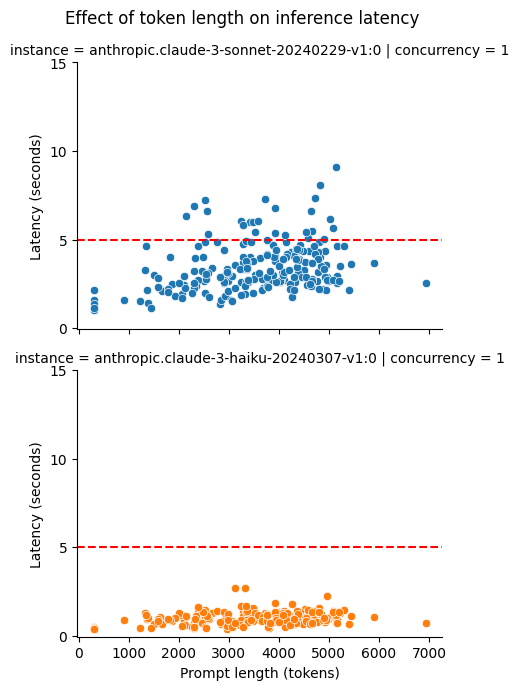

In [89]:
# Rename a column in the dataframe for clarity of the instance parameter of the model used
df_per_inference = df_per_inference.rename(columns={"instance_type": "instance"})
logger.info(f"df_per_inference.latency.quantile ->\n{df_per_inference.latency.quantile([0.25, 0.5, 0.75, 0.95, 0.99])}")
if df_per_inference.latency.quantile(0.5) < 1:
    print("multiplying by 1000")
    latency_units = "milliseconds"
    multiplier = 1000
    step_size = 500
    df_per_inference.latency = df_per_inference.latency*1000
else:
    multiplier = 10
    step_size = 5
    latency_units = "seconds"

## Initializing yticks and title for the chart
yticks: Optional[List] = None
title: Optional[str] = None

if config['report'].get('latency_vs_token_len_chart'):
    yticks: List = config['report']['latency_vs_token_len_chart'].get('y_ticks')
    title: str = config['report']['latency_vs_token_len_chart'].get('title')

if title is None:
    title = "Effect of token length on inference latency"

unique_instance_types = df_per_inference.instance.unique()
if len(unique_instance_types) == 1:
    logger.info(f"there is only {len(unique_instance_types)} instance type ({unique_instance_types}), "
                f"not using row as instance")
    # This created a FacetGrid for plotting multiple scatter plots based on 'instance' and 'concurrency' categories
    g = sns.FacetGrid(df_per_inference, col="concurrency", hue="instance", height=3.5, aspect=1.25, col_wrap=3)
else:
    logger.info(f"there are {len(unique_instance_types)} instance types ({unique_instance_types}), "
                f"using row as instance")
    g = sns.FacetGrid(df_per_inference, col="concurrency", row="instance", hue="instance", height=3.5, aspect=1.25)


## Subtitle of the facetgrid
g.fig.suptitle(title)
# # This will map a scatterplot to the FacetGrid for each subset of the data
sns_plot = g.map(sns.scatterplot, "prompt_tokens", "latency")

# flatten axes into a 1-d array
axes = g.axes.flatten()

# iterate through the axes
for i, ax in enumerate(axes):
    if latency_units == "milliseconds":
        m = 1000
    else:
        m = 1
    ax.axhline(config['report']['latency_budget']*m, ls='--', c='red')

# Set the y-axis label for all plots
g = g.set_ylabels(f"Latency ({latency_units})")
    
if yticks is None:
    # Y-axis ticks based on the maximum latency value and setting them in that manner
    yticks: List = list(range(0, (int(df_per_inference.latency.max())//multiplier+2)*multiplier, step_size))

if yticks is None:
    # Y-axis ticks based on the maximum latency value and setting them in that manner
    yticks: List = list(range(0, (int(df_per_inference.latency.max())//multiplier+1)*multiplier, step_size))
    logger.info(f"yticks was not configured, setting it to yticks[:10]={yticks[:10]}, "
                f"based on latency max of {df_per_inference.latency.max()}s, "
                f"multiplier={multiplier}, step_size={step_size}")
else:
    logger.info(f"yticks is configured, yticks={yticks}")
g = g.set(yticks=yticks)

# Set the x-axis label for all plots as the prompt length or tokens
g = g.set_xlabels("Prompt length (tokens)")

# Create a bytes buffer to save the plot
buffer = io.BytesIO()
sns_plot.savefig(buffer, format='png')
buffer.seek(0)  # Rewind buffer to the beginning

# Write the plot to S3
write_to_s3(buffer.getvalue(), BUCKET_NAME, "", METRICS_DIR, TOKENS_VS_LATENCY_PLOT_FNAME)
logger.info(f"Plot saved to s3://{BUCKET_NAME}/{METRICS_DIR}/{TOKENS_VS_LATENCY_PLOT_FNAME}")

# Optionally, display the plot
sns_plot

In [90]:
df_per_inference.latency.describe()

count    428.000000
mean       2.217725
std        1.577286
min        0.374843
25%        0.977187
50%        1.568596
75%        3.089818
max        9.097352
Name: latency, dtype: float64

#### Define the all metrics file path and read it to generate visualizations

In [91]:
all_metrics_fpath = os.path.join(METRICS_DIR, config["report"]["all_metrics_file"])
# Read the file from S3
try:
    logger.info(f"going to read all metrics file from {all_metrics_fpath}")
    file_content = get_s3_object(BUCKET_NAME, all_metrics_fpath)
    
    # Use pandas to read the CSV content
    df_all_metrics = pd.read_csv(io.StringIO(file_content))
    logger.info(f"{all_metrics_fpath} read into dataframe of shape {df_all_metrics.shape}")
    df_all_metrics.head()
except Exception as e:
    logger.error(f"Error reading from S3: {e}")

# if the instance count is not set then set it to 1, this happens
# in case of BYOE or Bedrock, so we want to count such a case as 1 compute unit

df_all_metrics['instance_count'] = df_all_metrics['instance_count'].fillna(1)
df_all_metrics.head()

[2024-08-12 23:42:13,907] p31041 {941246262.py:4} INFO - going to read all metrics file from fmbench-bedrock-anthropic-models-SageMaker-ExecutionRole-20240111T084686/data/metrics/yyyy=2024/mm=08/dd=12/hh=22/mm=16/all_metrics.csv
[2024-08-12 23:42:14,046] p31041 {941246262.py:9} INFO - fmbench-bedrock-anthropic-models-SageMaker-ExecutionRole-20240111T084686/data/metrics/yyyy=2024/mm=08/dd=12/hh=22/mm=16/all_metrics.csv read into dataframe of shape (428, 28)


,experiment_name,concurrency,payload_file,errors,successes,error_rate,all_prompts_token_count,prompt_token_count_mean,prompt_token_throughput,all_completions_token_count,...,TTFT_p50,TTFT_p99,TPOT_p50,TPOT_p99,instance_type,instance_count,EndpointName,ModelName,Image,S3Uri
0,anthropic.claude-3-sonnet-20240229-v1:0,1,payload_en_1-500.jsonl,[],1,0.0,299,299.0,189.03,31,...,NaN,NaN,NaN,NaN,anthropic.claude-3-sonnet-20240229-v1:0,1.0,NaN,NaN,NaN,NaN
1,anthropic.claude-3-sonnet-20240229-v1:0,1,payload_en_1-500.jsonl,[],1,0.0,299,299.0,297.58,31,...,NaN,NaN,NaN,NaN,anthropic.claude-3-sonnet-20240229-v1:0,1.0,NaN,NaN,NaN,NaN
2,anthropic.claude-3-sonnet-20240229-v1:0,1,payload_en_1-500.jsonl,[],1,0.0,299,299.0,138.58,31,...,NaN,NaN,NaN,NaN,anthropic.claude-3-sonnet-20240229-v1:0,1.0,NaN,NaN,NaN,NaN
3,anthropic.claude-3-sonnet-20240229-v1:0,1,payload_en_1-500.jsonl,[],1,0.0,299,299.0,223.40,31,...,NaN,NaN,NaN,NaN,anthropic.claude-3-sonnet-20240229-v1:0,1.0,NaN,NaN,NaN,NaN
4,anthropic.claude-3-sonnet-20240229-v1:0,1,payload_en_1-500.jsonl,[],1,0.0,299,299.0,263.46,31,...,NaN,NaN,NaN,NaN,anthropic.claude-3-sonnet-20240229-v1:0,1.0,NaN,NaN,NaN,NaN


In [92]:
## displaying all of the available columns in the all metrics dataframe
df_all_metrics.columns

Index(['experiment_name', 'concurrency', 'payload_file', 'errors', 'successes',
       'error_rate', 'all_prompts_token_count', 'prompt_token_count_mean',
       'prompt_token_throughput', 'all_completions_token_count',
       'completion_token_count_mean', 'completion_token_throughput',
       'transactions', 'transactions_per_second', 'transactions_per_minute',
       'latency_p50', 'latency_p95', 'latency_p99', 'TTFT_p50', 'TTFT_p99',
       'TPOT_p50', 'TPOT_p99', 'instance_type', 'instance_count',
       'EndpointName', 'ModelName', 'Image', 'S3Uri'],
      dtype='object')

In [93]:
df_all_metrics.instance_type

0      anthropic.claude-3-sonnet-20240229-v1:0
1      anthropic.claude-3-sonnet-20240229-v1:0
2      anthropic.claude-3-sonnet-20240229-v1:0
3      anthropic.claude-3-sonnet-20240229-v1:0
4      anthropic.claude-3-sonnet-20240229-v1:0
                        ...                   
423     anthropic.claude-3-haiku-20240307-v1:0
424     anthropic.claude-3-haiku-20240307-v1:0
425     anthropic.claude-3-haiku-20240307-v1:0
426     anthropic.claude-3-haiku-20240307-v1:0
427     anthropic.claude-3-haiku-20240307-v1:0
Name: instance_type, Length: 428, dtype: object

#### Display the number of experiment names within the metrics dataframe, instance types and models

In [94]:
experiments = df_all_metrics.experiment_name.unique()
instance_types = df_all_metrics.instance_type.unique()
# model_names = df_all_metrics.ModelName.unique()
# logger.info(f"contains information about {len(experiments)} experiments, {len(instance_types)} instance types, {len(model_names)} models")
logger.info(f"contains information about {len(experiments)} experiments, {len(instance_types)} instance types")

[2024-08-12 23:42:14,088] p31041 {1268470327.py:5} INFO - contains information about 2 experiments, 2 instance types


In [95]:
## extract some of the columns
relevant_cols = ['experiment_name',
                   'payload_file',
                     'instance_type',
                      'instance_count', 
                       'concurrency',
                         'error_rate',
                           'prompt_token_count_mean',
                             'prompt_token_throughput',
                               'completion_token_count_mean',
                                 'completion_token_throughput',
                                   #'latency_mean',
                                      'latency_p50',
                                        'latency_p95',
                                         'latency_p99',
                                         #'TTFT_mean',
                                         'TTFT_p50',
                                         #'TTFT_p95',
                                         'TTFT_p99',
                                          #'TPOT_mean',
                                           'TPOT_p50',
                                           # 'TPOT_p95',
                                             'TPOT_p99',
                                          # 'TTLT_mean',
                                          #  'TTLT_p50',
                                          #   'TTLT_p95',
                                          #    'TTLT_p99',
                                              'transactions_per_minute']

## initialize a group by columns to use further in generating portions of the dataframe and filtering it
group_by_cols = ['experiment_name',
                   'payload_file',
                     'instance_type',
                      'instance_count', 
                        'concurrency']


#### Create an 'experiment_counts.csv' to store metrics on experiment name, the payload file, concurrency and the total counts associated to that given experiment to visualize the distribution

In [96]:
df_all_metrics.instance_type.unique()

array(['anthropic.claude-3-sonnet-20240229-v1:0',
       'anthropic.claude-3-haiku-20240307-v1:0'], dtype=object)

In [97]:
df_counts = df_all_metrics[group_by_cols].value_counts().reset_index()

# Convert df_counts to CSV format
csv_buffer = io.StringIO()
df_counts.to_csv(csv_buffer, index=False)
csv_data = csv_buffer.getvalue()

# Define the file name and the S3 path
COUNTS_FNAME = "experiment_counts.csv"
counts_s3_path = os.path.join(METRICS_DIR, COUNTS_FNAME)

# Write the CSV data to S3
write_to_s3(csv_data, BUCKET_NAME, "", METRICS_DIR, COUNTS_FNAME)
logger.info(f"Counts DataFrame saved to s3://{BUCKET_NAME}/{counts_s3_path}")

df_counts

[2024-08-12 23:42:14,242] p31041 {1658785053.py:14} INFO - Counts DataFrame saved to s3://sagemaker-fmbench-write-us-east-1-015469603702/fmbench-bedrock-anthropic-models-SageMaker-ExecutionRole-20240111T084686/data/metrics/yyyy=2024/mm=08/dd=12/hh=22/mm=16/experiment_counts.csv


,experiment_name,payload_file,instance_type,instance_count,concurrency,count
0,anthropic.claude-3-sonnet-20240229-v1:0,payload_en_3000-4000.jsonl,anthropic.claude-3-sonnet-20240229-v1:0,1.0,1,105
1,anthropic.claude-3-haiku-20240307-v1:0,payload_en_3000-4000.jsonl,anthropic.claude-3-haiku-20240307-v1:0,1.0,1,105
2,anthropic.claude-3-sonnet-20240229-v1:0,payload_en_2000-3000.jsonl,anthropic.claude-3-sonnet-20240229-v1:0,1.0,1,67
3,anthropic.claude-3-haiku-20240307-v1:0,payload_en_2000-3000.jsonl,anthropic.claude-3-haiku-20240307-v1:0,1.0,1,67
4,anthropic.claude-3-sonnet-20240229-v1:0,payload_en_1000-2000.jsonl,anthropic.claude-3-sonnet-20240229-v1:0,1.0,1,32
5,anthropic.claude-3-haiku-20240307-v1:0,payload_en_1000-2000.jsonl,anthropic.claude-3-haiku-20240307-v1:0,1.0,1,32
6,anthropic.claude-3-haiku-20240307-v1:0,payload_en_1-500.jsonl,anthropic.claude-3-haiku-20240307-v1:0,1.0,1,5
7,anthropic.claude-3-haiku-20240307-v1:0,payload_en_500-1000.jsonl,anthropic.claude-3-haiku-20240307-v1:0,1.0,1,5
8,anthropic.claude-3-sonnet-20240229-v1:0,payload_en_1-500.jsonl,anthropic.claude-3-sonnet-20240229-v1:0,1.0,1,5
9,anthropic.claude-3-sonnet-20240229-v1:0,payload_en_500-1000.jsonl,anthropic.claude-3-sonnet-20240229-v1:0,1.0,1,5


#### Display the mean error rates for each experiment with different congifurations using the same columns of interest used in the cell above

In [98]:
df_error_rates = df_all_metrics.groupby(group_by_cols).agg({'error_rate': 'mean'}).reset_index()
df_error_rates = df_error_rates.round(2)

csv_buffer = io.StringIO()
df_error_rates.to_csv(csv_buffer, index=False)
error_csv = csv_buffer.getvalue()

# Define the file name and the S3 path
ERROR_RATES_FNAME: str = "error_rates.csv"
counts_s3_path = os.path.join(METRICS_DIR, ERROR_RATES_FNAME)

# Write the CSV data to S3
write_to_s3(error_csv, BUCKET_NAME, "", METRICS_DIR, ERROR_RATES_FNAME)
logger.info(f"Error Counts DataFrame saved to s3://{BUCKET_NAME}/{counts_s3_path}")

df_error_rates

[2024-08-12 23:42:14,439] p31041 {3093561034.py:14} INFO - Error Counts DataFrame saved to s3://sagemaker-fmbench-write-us-east-1-015469603702/fmbench-bedrock-anthropic-models-SageMaker-ExecutionRole-20240111T084686/data/metrics/yyyy=2024/mm=08/dd=12/hh=22/mm=16/error_rates.csv


,experiment_name,payload_file,instance_type,instance_count,concurrency,error_rate
0,anthropic.claude-3-haiku-20240307-v1:0,payload_en_1-500.jsonl,anthropic.claude-3-haiku-20240307-v1:0,1.0,1,0.0
1,anthropic.claude-3-haiku-20240307-v1:0,payload_en_1000-2000.jsonl,anthropic.claude-3-haiku-20240307-v1:0,1.0,1,0.0
2,anthropic.claude-3-haiku-20240307-v1:0,payload_en_2000-3000.jsonl,anthropic.claude-3-haiku-20240307-v1:0,1.0,1,0.0
3,anthropic.claude-3-haiku-20240307-v1:0,payload_en_3000-4000.jsonl,anthropic.claude-3-haiku-20240307-v1:0,1.0,1,0.0
4,anthropic.claude-3-haiku-20240307-v1:0,payload_en_500-1000.jsonl,anthropic.claude-3-haiku-20240307-v1:0,1.0,1,0.0
5,anthropic.claude-3-sonnet-20240229-v1:0,payload_en_1-500.jsonl,anthropic.claude-3-sonnet-20240229-v1:0,1.0,1,0.0
6,anthropic.claude-3-sonnet-20240229-v1:0,payload_en_1000-2000.jsonl,anthropic.claude-3-sonnet-20240229-v1:0,1.0,1,0.0
7,anthropic.claude-3-sonnet-20240229-v1:0,payload_en_2000-3000.jsonl,anthropic.claude-3-sonnet-20240229-v1:0,1.0,1,0.0
8,anthropic.claude-3-sonnet-20240229-v1:0,payload_en_3000-4000.jsonl,anthropic.claude-3-sonnet-20240229-v1:0,1.0,1,0.0
9,anthropic.claude-3-sonnet-20240229-v1:0,payload_en_500-1000.jsonl,anthropic.claude-3-sonnet-20240229-v1:0,1.0,1,0.0


### Visualize Inference error rates across different concurrency levels and instance types

[2024-08-12 23:42:14,471] p31041 {1032143938.py:7} INFO - df_error_rates -->                            experiment_name       dataset  \
0   anthropic.claude-3-haiku-20240307-v1:0      en_1-500   
1   anthropic.claude-3-haiku-20240307-v1:0  en_1000-2000   
2   anthropic.claude-3-haiku-20240307-v1:0  en_2000-3000   
3   anthropic.claude-3-haiku-20240307-v1:0  en_3000-4000   
4   anthropic.claude-3-haiku-20240307-v1:0   en_500-1000   
5  anthropic.claude-3-sonnet-20240229-v1:0      en_1-500   
6  anthropic.claude-3-sonnet-20240229-v1:0  en_1000-2000   
7  anthropic.claude-3-sonnet-20240229-v1:0  en_2000-3000   
8  anthropic.claude-3-sonnet-20240229-v1:0  en_3000-4000   
9  anthropic.claude-3-sonnet-20240229-v1:0   en_500-1000   

                                  instance  instance_count  concurrency  \
0   anthropic.claude-3-haiku-20240307-v1:0             1.0            1   
1   anthropic.claude-3-haiku-20240307-v1:0             1.0            1   
2   anthropic.claude-3-haiku-20240307

<Axes: title={'center': 'Inference error rates for different concurrency levels and instance types\nError rate is zero for all experiment runs.'}, xlabel='Concurrency level', ylabel='Error rate (failed / total inferences)'>

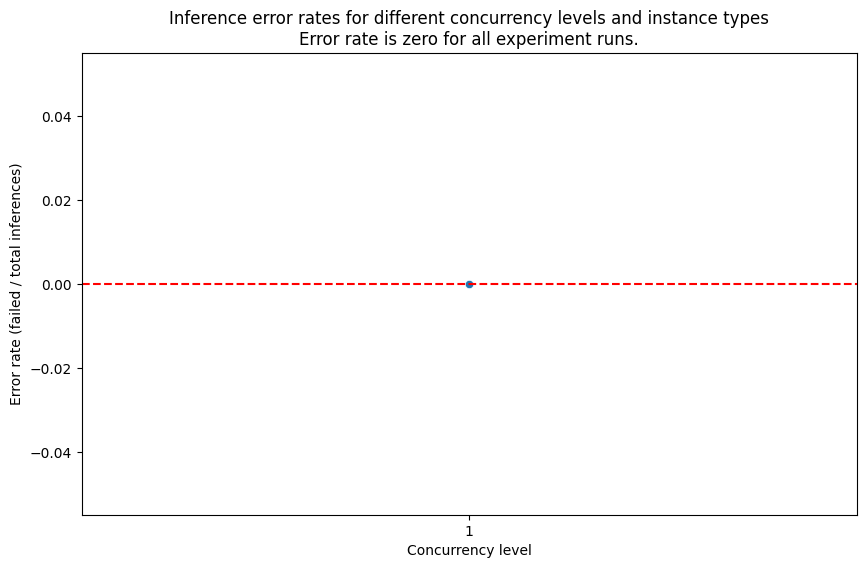

In [99]:
df_error_rates = df_error_rates.rename(columns={"instance_type": "instance", "payload_file": "dataset"})

# Clean up the dataset names by removing json file extensions and prefixes
df_error_rates.dataset = df_error_rates.dataset.map(lambda x: x.replace(".jsonl", "").replace("payload_", ""))

# this creates a facetGrid for plotting scatter plots based on 'instance' and 'dataset'
logger.info(f"df_error_rates --> {df_error_rates}")

df_error_rates_only_nz = df_error_rates[df_error_rates.error_rate > 0]
logger.info(f"there are {df_error_rates_only_nz.shape[0]} experiment runs that encountered errors")
if df_error_rates_only_nz.shape[0] > 0:    
    g = sns.FacetGrid(df_error_rates_only_nz, col="instance", row="dataset", hue="instance", height=3.5, aspect=1.25)
    # Maps a scatterplot to the FacetGrid for each subset of the data
    sns_plot = g.map(sns.scatterplot, "concurrency", "error_rate")
    # flatten axes into a 1-d array
    axes = g.axes.flatten()

    # iterate through the axes
    for i, ax in enumerate(axes):
        ax.axhline(config['report']['error_rate_budget']*1000, ls='--', c='red')

    # Create a subtitle
    with sns.plotting_context('paper', font_scale = 1.3):
        g.fig.suptitle("Inference error rates for different concurrency levels and instance types\nOnly non-zero error rates shown.")
        g.set_titles(row_template="{row_name}", col_template="{col_name}", size=8)

    # Set x and y labels for this chart
    g = g.set_ylabels("Error rate (failed / total inferences)")
    g = g.set_xlabels("Concurrency level")
    g.figure.subplots_adjust(top=.8)
    sns_plot.savefig(buffer, format='png')
    buffer.seek(0)
else:
    # create a new dummy dataframe just for plotting an empty chart
    
    df_error_rates_only_nz = pd.DataFrame({"concurrency": df_error_rates.concurrency.unique(),
                                           "error_rate": [0]*len(df_error_rates.concurrency.unique())
                                          })
    sns_plot = sns.scatterplot(data=df_error_rates_only_nz, x="concurrency", y="error_rate")
    sns_plot.set_xticks(df_error_rates_only_nz.concurrency.unique())
    sns_plot.set(xlabel="Concurrency level",
                 ylabel="Error rate (failed / total inferences)",
                 title="Inference error rates for different concurrency levels and instance types\nError rate is zero for all experiment runs.")
    sns_plot.axhline(config['report']['error_rate_budget']*1000, ls='--', c='red')
    sns_plot.figure.savefig(buffer, format='png')
    buffer.seek(0)

# Write the plot to S3
write_to_s3(buffer.getvalue(), BUCKET_NAME, "", METRICS_DIR, ERROR_RATES_PLOT_FNAME)
logger.info(f"Plot saved to s3://{BUCKET_NAME}/{METRICS_DIR}/{ERROR_RATES_PLOT_FNAME}")

## Display the plot 
sns_plot

#### Check for the df elements that have error rates above 0

In [100]:
df_error_rates_nz = df_error_rates[df_error_rates.error_rate > 0]
df_error_rates_nz

,experiment_name,dataset,instance,instance_count,concurrency,error_rate


In [101]:
## initialize a dataframe to get the mean of the columns in consideration
df_summary_metrics = df_all_metrics[relevant_cols].groupby(group_by_cols).mean().reset_index()

# ugly way of doing this, will refactor this later (maybe)
df_summary_metrics.fillna(PLACE_HOLDER, inplace=True)
int_cols = ['prompt_token_count_mean', 'prompt_token_throughput', 'completion_token_count_mean', 'completion_token_throughput', 'transactions_per_minute']
for ic in int_cols:
    df_summary_metrics[ic] = df_summary_metrics[ic].astype(int)

df_summary_metrics.replace(PLACE_HOLDER, np.nan, inplace=True)
#df_summary_metrics.latency_p95	= df_summary_metrics.latency_p95.round(2)
df_summary_metrics.latency_p50 = df_summary_metrics.latency_p50.round(2)
df_summary_metrics.latency_p95 = df_summary_metrics.latency_p95.round(2)
df_summary_metrics.latency_p99 = df_summary_metrics.latency_p99.round(2)
df_summary_metrics.TTFT_p50 = df_summary_metrics.TTFT_p50.round(4)
#df_summary_metrics.TTFT_p95 = df_summary_metrics.TTFT_p95.round(4)
df_summary_metrics.TTFT_p99 = df_summary_metrics.TTFT_p99.round(4)
df_summary_metrics.TPOT_p50 = df_summary_metrics.TPOT_p50.round(4)
#df_summary_metrics.TPOT_p95 = df_summary_metrics.TPOT_p95.round(4)
df_summary_metrics.TPOT_p99 = df_summary_metrics.TPOT_p99.round(4)
# df_summary_metrics.TTLT_p50 = df_summary_metrics.TTLT_p50.round(4)
# df_summary_metrics.TTLT_p95 = df_summary_metrics.TTLT_p95.round(4)
# df_summary_metrics.TTLT_p99 = df_summary_metrics.TTLT_p99.round(4)
df_summary_metrics.error_rate = df_summary_metrics.error_rate.round(2)

# drop the columns if all, TTFT, TPOT and TTLT are NaN
time_to_token_cols_to_check = [col for col in df_summary_metrics.columns if col.startswith(('TTFT', 'TTLT', 'TPOT'))]
for col in time_to_token_cols_to_check:
    if df_summary_metrics[col].isna().all():
        df_summary_metrics.drop(columns=col, inplace=True)
logger.info(f"Updated summary metrics cols: {df_summary_metrics.columns}")

csv_buffer = io.StringIO()
df_summary_metrics.to_csv(csv_buffer, index=False)
summary_metrics_csv = csv_buffer.getvalue()

# Define the file name for S3 based on the original file path
summary_file_name = all_metrics_fpath.replace("all_metrics", "all_metrics_summary").split('/')[-1] 
summary_s3_path = os.path.join(METRICS_DIR, summary_file_name)  # Define full S3 path

# Write the CSV data to S3
write_to_s3(summary_metrics_csv, BUCKET_NAME, "", METRICS_DIR, summary_file_name)
logger.info(f"Summary metrics DataFrame saved to s3://{BUCKET_NAME}/{summary_s3_path}")

df_summary_metrics

[2024-08-12 23:42:14,961] p31041 {258799924.py:31} INFO - Updated summary metrics cols: Index(['experiment_name', 'payload_file', 'instance_type', 'instance_count',
       'concurrency', 'error_rate', 'prompt_token_count_mean',
       'prompt_token_throughput', 'completion_token_count_mean',
       'completion_token_throughput', 'latency_p50', 'latency_p95',
       'latency_p99', 'transactions_per_minute'],
      dtype='object')
[2024-08-12 23:42:15,061] p31041 {258799924.py:43} INFO - Summary metrics DataFrame saved to s3://sagemaker-fmbench-write-us-east-1-015469603702/fmbench-bedrock-anthropic-models-SageMaker-ExecutionRole-20240111T084686/data/metrics/yyyy=2024/mm=08/dd=12/hh=22/mm=16/all_metrics_summary.csv


,experiment_name,payload_file,instance_type,instance_count,concurrency,error_rate,prompt_token_count_mean,prompt_token_throughput,completion_token_count_mean,completion_token_throughput,latency_p50,latency_p95,latency_p99,transactions_per_minute
0,anthropic.claude-3-haiku-20240307-v1:0,payload_en_1-500.jsonl,anthropic.claude-3-haiku-20240307-v1:0,1.0,1,0.0,299,686,30,68,0.43,0.43,0.43,137
1,anthropic.claude-3-haiku-20240307-v1:0,payload_en_1000-2000.jsonl,anthropic.claude-3-haiku-20240307-v1:0,1.0,1,0.0,2065,2318,64,66,0.95,0.95,0.95,67
2,anthropic.claude-3-haiku-20240307-v1:0,payload_en_2000-3000.jsonl,anthropic.claude-3-haiku-20240307-v1:0,1.0,1,0.0,3164,3497,58,54,1.04,1.04,1.04,67
3,anthropic.claude-3-haiku-20240307-v1:0,payload_en_3000-4000.jsonl,anthropic.claude-3-haiku-20240307-v1:0,1.0,1,0.0,4515,4589,64,59,1.05,1.05,1.05,60
4,anthropic.claude-3-haiku-20240307-v1:0,payload_en_500-1000.jsonl,anthropic.claude-3-haiku-20240307-v1:0,1.0,1,0.0,1277,1743,60,75,0.79,0.79,0.79,81
5,anthropic.claude-3-sonnet-20240229-v1:0,payload_en_1-500.jsonl,anthropic.claude-3-sonnet-20240229-v1:0,1.0,1,0.0,299,222,31,23,1.43,1.43,1.43,44
6,anthropic.claude-3-sonnet-20240229-v1:0,payload_en_1000-2000.jsonl,anthropic.claude-3-sonnet-20240229-v1:0,1.0,1,0.0,2065,777,72,26,3.07,3.07,3.07,22
7,anthropic.claude-3-sonnet-20240229-v1:0,payload_en_2000-3000.jsonl,anthropic.claude-3-sonnet-20240229-v1:0,1.0,1,0.0,3164,1042,72,21,3.47,3.47,3.47,19
8,anthropic.claude-3-sonnet-20240229-v1:0,payload_en_3000-4000.jsonl,anthropic.claude-3-sonnet-20240229-v1:0,1.0,1,0.0,4515,1360,69,19,3.67,3.67,3.67,17
9,anthropic.claude-3-sonnet-20240229-v1:0,payload_en_500-1000.jsonl,anthropic.claude-3-sonnet-20240229-v1:0,1.0,1,0.0,1277,694,59,29,1.93,1.93,1.93,32


In [102]:
df_summary_metrics_nz = df_summary_metrics[df_summary_metrics.error_rate == 0]
logger.info(f"there are {len(df_summary_metrics_nz)} entries out of {len(df_summary_metrics)} in the summary data for which error rate is 0")

[2024-08-12 23:42:15,089] p31041 {3483828648.py:2} INFO - there are 10 entries out of 10 in the summary data for which error rate is 0


In [103]:
df_summary_metrics_dataset = df_summary_metrics[df_summary_metrics.payload_file.str.contains(config['metrics']['dataset_of_interest'])]
logger.info(f"shape of dataframe with summary metrics for {config['metrics']['dataset_of_interest']} is {df_summary_metrics_dataset.shape}")

csv_buffer = io.StringIO()
df_summary_metrics_dataset.to_csv(csv_buffer, index=False)
metrics_dataset = csv_buffer.getvalue()

# Write the CSV data to S3
write_to_s3(metrics_dataset, BUCKET_NAME, "", METRICS_DIR, SUMMARY_METRICS_W_PRICING_FNAME)
logger.info(f"Summary metrics dataset saved to s3://{BUCKET_NAME}/{METRICS_DIR}/{SUMMARY_METRICS_W_PRICING_FNAME}")

df_summary_metrics_dataset

[2024-08-12 23:42:15,100] p31041 {2401216161.py:2} INFO - shape of dataframe with summary metrics for en_3000-4000 is (2, 14)
[2024-08-12 23:42:15,199] p31041 {2401216161.py:10} INFO - Summary metrics dataset saved to s3://sagemaker-fmbench-write-us-east-1-015469603702/fmbench-bedrock-anthropic-models-SageMaker-ExecutionRole-20240111T084686/data/metrics/yyyy=2024/mm=08/dd=12/hh=22/mm=16/summary_metrics_w_pricing.csv


,experiment_name,payload_file,instance_type,instance_count,concurrency,error_rate,prompt_token_count_mean,prompt_token_throughput,completion_token_count_mean,completion_token_throughput,latency_p50,latency_p95,latency_p99,transactions_per_minute
3,anthropic.claude-3-haiku-20240307-v1:0,payload_en_3000-4000.jsonl,anthropic.claude-3-haiku-20240307-v1:0,1.0,1,0.0,4515,4589,64,59,1.05,1.05,1.05,60
8,anthropic.claude-3-sonnet-20240229-v1:0,payload_en_3000-4000.jsonl,anthropic.claude-3-sonnet-20240229-v1:0,1.0,1,0.0,4515,1360,69,19,3.67,3.67,3.67,17


[2024-08-12 23:42:15,232] p31041 {2001225109.py:10} ERROR - found 210 experiment runs for ds=en_3000-4000
[2024-08-12 23:42:15,436] p31041 {category.py:223} INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2024-08-12 23:42:15,447] p31041 {category.py:223} INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


[2024-08-12 23:42:15,990] p31041 {2001225109.py:34} INFO - Plot saved to s3://sagemaker-fmbench-write-us-east-1-015469603702/fmbench-bedrock-anthropic-models-SageMaker-ExecutionRole-20240111T084686/data/metrics/yyyy=2024/mm=08/dd=12/hh=22/mm=16/concurrency_vs_inference_latency.png


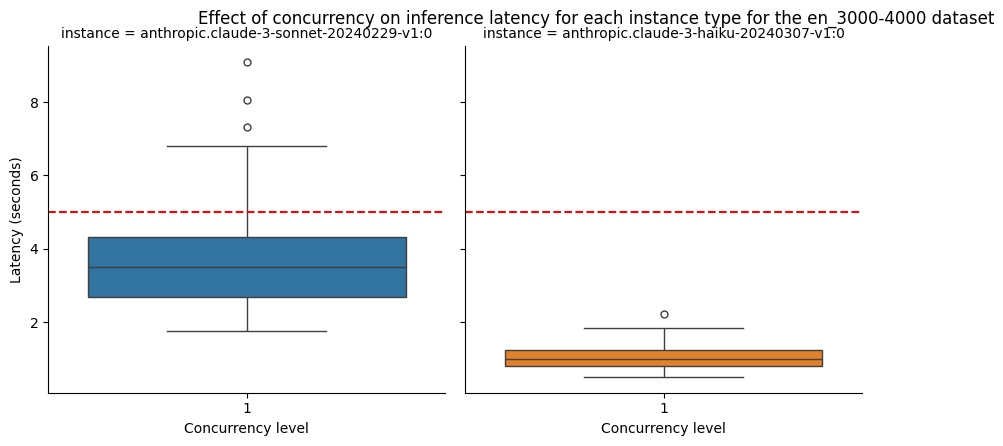

In [104]:
df_all_metrics_for_dataset = df_all_metrics.rename(columns={"instance_type": "instance", "payload_file": "dataset"})
df_all_metrics_for_dataset.dataset = df_all_metrics_for_dataset.dataset.map(lambda x: x.replace(".jsonl", "").replace("payload_", ""))
ds = config['metrics']['dataset_of_interest']
df_all_metrics_for_dataset = df_all_metrics_for_dataset[df_all_metrics_for_dataset.dataset.str.contains(ds)]
row_order = list(df_all_metrics_for_dataset[["instance", "latency_p95"]].groupby("instance").mean("latency_p95").reset_index()["instance"])
if len(row_order) == 0:
    logger.error(f"seems like a missing configuration, no data found in df_all_metrics_for_dataset for ds={ds}")
    col_wrap = 1
else:    
    logger.error(f"found {df_all_metrics_for_dataset.shape[0]} experiment runs for ds={ds}")
    col_wrap = 4 if len(row_order) > 4 else len(row_order)

    sns_plot = sns.catplot(
        data=df_all_metrics_for_dataset, x='concurrency', y='latency_p95',
        col='instance', kind='box', col_wrap=col_wrap, hue="instance", row_order=row_order, height=4.5, aspect=1.0
    )
    # flatten axes into a 1-d array
    axes = sns_plot.axes.flatten()

    # iterate through the axes
    for i, ax in enumerate(axes):
        ax.axhline(config['report']['latency_budget'], ls='--', c='red')
    sns_plot._legend.remove()
    sns_plot.fig.suptitle(f"Effect of concurrency on inference latency for each instance type for the {ds} dataset\n\n")
    sns_plot = sns_plot.set_ylabels("Latency (seconds)")
    sns_plot = sns_plot.set_xlabels("Concurrency level")
    sns_plot.fig.subplots_adjust(top=0.9)

    sns_plot.savefig(buffer, format='png')
    buffer.seek(0)

    # Write the plot to S3
    write_to_s3(buffer.getvalue(), BUCKET_NAME, "", METRICS_DIR, CONCURRENCY_VS_INFERENCE_LATENCY_PLOT_FNAME)
    logger.info(f"Plot saved to s3://{BUCKET_NAME}/{METRICS_DIR}/{CONCURRENCY_VS_INFERENCE_LATENCY_PLOT_FNAME}")

In [105]:
df_pricing = pd.DataFrame.from_dict(pricing_config['pricing'], orient='index').reset_index()
df_pricing

,index,ml.m5.xlarge,ml.g5.xlarge,ml.g5.2xlarge,ml.g5.12xlarge,ml.g5.24xlarge,ml.g5.48xlarge,ml.inf2.xlarge,ml.inf2.8xlarge,ml.inf2.24xlarge,...,mistral.mistral-7b-instruct-v0:2,mistral.mixtral-8x7b-instruct-v0:1,meta.llama3-8b-instruct-v1:0,meta.llama3-70b-instruct-v1:0,meta.llama2-13b-chat-v1,meta.llama2-70b-chat-v1,ai21.j2-mid-v1,ai21.j2-ultra-v1,cohere.command-text-v14,cohere.command-light-text-v14
0,instance_based,0.23,1.4084,1.515,7.09,10.18,20.36,0.99,2.36,7.79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,token_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"{'input-per-1k-tokens': 0.00015, 'output-per-1...","{'input-per-1k-tokens': 0.00045, 'output-per-1...","{'input-per-1k-tokens': 0.0004, 'output-per-1k...","{'input-per-1k-tokens': 0.00265, 'output-per-1...","{'input-per-1k-tokens': 0.00075, 'output-per-1...","{'input-per-1k-tokens': 0.00195, 'output-per-1...","{'input-per-1k-tokens': 0.0125, 'output-per-1k...","{'input-per-1k-tokens': 0.0188, 'output-per-1k...","{'input-per-1k-tokens': 0.0015, 'output-per-1k...","{'input-per-1k-tokens': 0.0003, 'output-per-1k..."


In [106]:
df_summary_metrics_dataset

,experiment_name,payload_file,instance_type,instance_count,concurrency,error_rate,prompt_token_count_mean,prompt_token_throughput,completion_token_count_mean,completion_token_throughput,latency_p50,latency_p95,latency_p99,transactions_per_minute
3,anthropic.claude-3-haiku-20240307-v1:0,payload_en_3000-4000.jsonl,anthropic.claude-3-haiku-20240307-v1:0,1.0,1,0.0,4515,4589,64,59,1.05,1.05,1.05,60
8,anthropic.claude-3-sonnet-20240229-v1:0,payload_en_3000-4000.jsonl,anthropic.claude-3-sonnet-20240229-v1:0,1.0,1,0.0,4515,1360,69,19,3.67,3.67,3.67,17


### Handle pricing for token based pricing & hourly (instance type) pricing models

In [107]:
def calculate_cost_per_txn(row: pd.Series, pricing: Dict) -> Optional[float]:
    """
    The instance type is supposed to be unique across all inference options
    whether it is hourly pricing based instances (g5/p4 etc.) or Bedrock
    model ids or anything else.
    """

    cost_per_txn: Optional[float] = None
    # check if this is instance type
    pricing_for_this_instance = pricing['pricing']['instance_based'].get(row['instance_type'])
    if pricing_for_this_instance:
        # this is instance based pricing so then cost per txn is simply
        logger.info(f"pricing for {row['instance_type']} -> {pricing_for_this_instance}")
        if row['transactions_per_minute'] > 0:
            instance_count = row.get('instance_count', 1)
            logger.info(f"calculate_cost_per_txn, instance_count={instance_count}")
            cost_per_txn = ((pricing_for_this_instance / 60) * instance_count) / row['transactions_per_minute']
        else:
            logger.info(f"transactions_per_minute={row['transactions_per_minute']}, setting cost_per_txn=None")
            cost_per_txn = None
            
    else:
        # this is token based pricing
        token_based_pricing_this_model = pricing['pricing']['token_based'].get(row['instance_type'])
        logger.info(f"pricing for {row['instance_type']} -> {token_based_pricing_this_model}")
        if token_based_pricing_this_model:
            input_token_cost = (row['prompt_token_count_mean']/1000) * \
                                token_based_pricing_this_model['input-per-1k-tokens']
            output_token_cost = (row['completion_token_count_mean']/1000) * \
                                token_based_pricing_this_model['output-per-1k-tokens']
            cost_per_txn = input_token_cost + output_token_cost
        else:
            logger.error(f"no pricing information found for {row['instance_type']}")
    return cost_per_txn

In [108]:
df_summary_metrics_dataset['price_per_txn'] = df_summary_metrics_dataset.apply(lambda r: calculate_cost_per_txn(r, pricing_config),
                                                                               axis=1)

[2024-08-12 23:42:16,218] p31041 {3928684410.py:25} INFO - pricing for anthropic.claude-3-haiku-20240307-v1:0 -> {'input-per-1k-tokens': 0.00025, 'output-per-1k-tokens': 0.00125}
[2024-08-12 23:42:16,220] p31041 {3928684410.py:25} INFO - pricing for anthropic.claude-3-sonnet-20240229-v1:0 -> {'input-per-1k-tokens': 0.003, 'output-per-1k-tokens': 0.015}
/tmp/ipykernel_31041/217009477.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [109]:
df_summary_metrics_dataset['price_per_token'] = (df_summary_metrics_dataset['price_per_txn'] / 
                                                (df_summary_metrics_dataset['prompt_token_count_mean'] + 
                                                 df_summary_metrics_dataset['completion_token_count_mean']))

df_summary_metrics_dataset['price_per_token'] = df_summary_metrics_dataset['price_per_token'].apply(lambda x: '{:.8f}'.format(x))

/tmp/ipykernel_31041/3444174930.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_31041/3444174930.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [110]:
df_summary_metrics_dataset

,experiment_name,payload_file,instance_type,instance_count,concurrency,error_rate,prompt_token_count_mean,prompt_token_throughput,completion_token_count_mean,completion_token_throughput,latency_p50,latency_p95,latency_p99,transactions_per_minute,price_per_txn,price_per_token
3,anthropic.claude-3-haiku-20240307-v1:0,payload_en_3000-4000.jsonl,anthropic.claude-3-haiku-20240307-v1:0,1.0,1,0.0,4515,4589,64,59,1.05,1.05,1.05,60,0.001209,0.00000026
8,anthropic.claude-3-sonnet-20240229-v1:0,payload_en_3000-4000.jsonl,anthropic.claude-3-sonnet-20240229-v1:0,1.0,1,0.0,4515,1360,69,19,3.67,3.67,3.67,17,0.014580,0.00000318


In [111]:
def score_run(row: pd.core.series.Series, config: Dict) -> Dict:
    """
    check all criteria configured in the report section of the config
    these are error rates, latency and cost to determine the "score"
    for each run in the following way:
    1. Set score to 0, criteria failed to false.
    2. If the run has an error rate lte to the error rate budget,
       add 1 to the score otherwise set set criteria failed to true.
    3. If the run has a price per 10k txns lte to the cost budget,
       add 1 to the score otherwise set set criteria failed to true.
    4. If the run has p95 latency lte to the latency budget,
       add 1 to the score otherwise set set criteria failed to true.
    5. If criteria failed is false add the concurrency to the score.
    The idea that we want to select runs that satisfy cost/error rate/latency criteria
    and out of those prefer the run with the highest level of concurrency.
    """
    score: float = 0
    point_per_criterion: int = 1
    any_criterion_failed: bool = False
    error_rate_criterion_failed: bool = False
    cost_per_txn_criterion_failed: bool = False
    latency_criterion_failed: bool = False

    mk_text_green = lambda k, m=1: f"<span style='color:green'>{row[k]*m:0.2f}</span>"
    mk_text_red = lambda k, m=1: f"<span style='color:red'>**{row[k]*m:0.2f}**</span>"
    mk_text_red2 = lambda k: f"<span style='color:red'>**{row[k]}**</span>"
    
    # error rate
    threshold: float = config['report'].get('error_rate_budget', 0)
    if row['error_rate'] <= threshold:
        score += point_per_criterion
        error_rate_text = mk_text_green('error_rate')
    else:
        error_rate_criterion_failed = True
        error_rate_text = mk_text_red('error_rate')
        logger.info(f"score_run, experiment_name={row['experiment_name']}, setting "
                    f"error_rate_criterion_failed={error_rate_criterion_failed} because "
                    f"error_rate={row['error_rate']} > threshold={threshold}")

    # latency
    threshold: float = config['report'].get('latency_budget', 10)
    if row['latency_p95'] <= threshold:
        # extra points for better latency
        score += point_per_criterion + (threshold-row['latency_p95'])/threshold
        latency_p95_text = mk_text_green('latency_p95')
    else:
        latency_criterion_failed = True
        latency_p95_text = mk_text_red('latency_p95')
        logger.info(f"score_run, experiment_name={row['experiment_name']}, setting "
                    f"latency_criterion_failed={latency_criterion_failed} because "
                    f"latency_p95={row['latency_p95']} > threshold={threshold}")

    # cost_per_10k_txn_budget
    threshold: float = config['report'].get('cost_per_10k_txn_budget', 5)
    if row['price_per_txn'] and row['price_per_txn'] * 10000 <= threshold:
        # extra points for better price
        score += point_per_criterion + (threshold-(row['price_per_txn']* 10000))/threshold     
        price_per_10k_txn_text = mk_text_green('price_per_txn', m=10000)
    else:
        cost_per_txn_criterion_failed = True
        if row['price_per_txn']:
            price_per_10k_txn_text = mk_text_red('price_per_txn', m=10000)
            cost_per_10k_txn = row['price_per_txn'] * 10000
        else:
            cost_per_10k_txn = None
            price_per_10k_txn_text = mk_text_red2('price_per_txn')

        logger.info(f"score_run, experiment_name={row['experiment_name']}, setting "
                    f"cost_per_txn_criterion_failed={cost_per_txn_criterion_failed} because "
                    f"cost_per_10k_txn={cost_per_10k_txn} > threshold={threshold}")

    # if all criteria passed then add points for concurrency
    # we want to select the run with the highest concurrency amongst
    # all runs that satisfy all criteria
    any_criterion_failed = error_rate_criterion_failed or \
                           latency_criterion_failed or \
                           cost_per_txn_criterion_failed

    if any_criterion_failed is True:
        logger.info(f"experiment_name={row['experiment_name']}, not adding points for "
                    f"concurrency because any_criterion_failed={any_criterion_failed}")
    else:
        score += row['concurrency']

    score_dict = dict(score=score,
                      any_criterion_failed=any_criterion_failed,
                      error_rate_criterion_failed=error_rate_criterion_failed,
                      latency_criterion_failed=latency_criterion_failed,
                      cost_per_txn_criterion_failed=cost_per_txn_criterion_failed,
                      error_rate_text=error_rate_text,
                      latency_p95_text=latency_p95_text,
                      price_per_10k_txn_text=price_per_10k_txn_text)
    logger.info(json.dumps(row.to_dict() | score_dict, indent=2, default=str))
    return score_dict

In [112]:
df_summary_metrics_dataset['score_dict'] = df_summary_metrics_dataset.apply(lambda row: score_run(row, config), axis=1)
score_keys = df_summary_metrics_dataset.score_dict.iloc[0].keys()
for k in score_keys:
    df_summary_metrics_dataset[k] = df_summary_metrics_dataset.score_dict.map(lambda d: d[k])

[2024-08-12 23:42:16,272] p31041 {2835114254.py:93} INFO - {
  "experiment_name": "anthropic.claude-3-haiku-20240307-v1:0",
  "payload_file": "payload_en_3000-4000.jsonl",
  "instance_type": "anthropic.claude-3-haiku-20240307-v1:0",
  "instance_count": 1.0,
  "concurrency": 1,
  "error_rate": 0.0,
  "prompt_token_count_mean": 4515,
  "prompt_token_throughput": 4589,
  "completion_token_count_mean": 64,
  "completion_token_throughput": 59,
  "latency_p50": 1.05,
  "latency_p95": 1.05,
  "latency_p99": 1.05,
  "transactions_per_minute": 60,
  "price_per_txn": 0.00120875,
  "price_per_token": "0.00000026",
  "score": 5.755464285714286,
  "any_criterion_failed": false,
  "error_rate_criterion_failed": false,
  "latency_criterion_failed": false,
  "cost_per_txn_criterion_failed": false,
  "error_rate_text": "<span style='color:green'>0.00</span>",
  "latency_p95_text": "<span style='color:green'>1.05</span>",
  "price_per_10k_txn_text": "<span style='color:green'>12.09</span>"
}
[2024-08-12

In [113]:
df_summary_metrics_dataset = df_summary_metrics_dataset.sort_values(by="score", ascending=False)
file_path_df = os.path.join(METRICS_DIR, SUMMARY_METRICS_FOR_DATASET_W_SCORES_FNAME)

csv_buffer = io.StringIO()
os.makedirs(os.path.dirname(file_path_df), exist_ok=True)
df_summary_metrics_dataset.to_csv(file_path_df, index=False)
summary_metrics_dataset_csv = csv_buffer.getvalue()

# Write the CSV data to S3
write_to_s3(summary_metrics_dataset_csv, config['aws']['bucket'], "", METRICS_DIR, SUMMARY_METRICS_FOR_DATASET_W_SCORES_FNAME)
logger.info(f"Summary metrics dataset saved to s3://{config['aws']['bucket']}/{METRICS_DIR}/{SUMMARY_METRICS_FOR_DATASET_W_SCORES_FNAME}")

df_summary_metrics_dataset

[2024-08-12 23:42:16,404] p31041 {3750655657.py:11} INFO - Summary metrics dataset saved to s3://sagemaker-fmbench-write-us-east-1-015469603702/fmbench-bedrock-anthropic-models-SageMaker-ExecutionRole-20240111T084686/data/metrics/yyyy=2024/mm=08/dd=12/hh=22/mm=16/summary_metrics_for_dataset_w_scores.csv


,experiment_name,payload_file,instance_type,instance_count,concurrency,error_rate,prompt_token_count_mean,prompt_token_throughput,completion_token_count_mean,completion_token_throughput,...,price_per_token,score_dict,score,any_criterion_failed,error_rate_criterion_failed,latency_criterion_failed,cost_per_txn_criterion_failed,error_rate_text,latency_p95_text,price_per_10k_txn_text
3,anthropic.claude-3-haiku-20240307-v1:0,payload_en_3000-4000.jsonl,anthropic.claude-3-haiku-20240307-v1:0,1.0,1,0.0,4515,4589,64,59,...,0.00000026,"{'score': 5.755464285714286, 'any_criterion_fa...",5.755464,False,False,False,False,<span style='color:green'>0.00</span>,<span style='color:green'>1.05</span>,<span style='color:green'>12.09</span>
8,anthropic.claude-3-sonnet-20240229-v1:0,payload_en_3000-4000.jsonl,anthropic.claude-3-sonnet-20240229-v1:0,1.0,1,0.0,4515,1360,69,19,...,0.00000318,"{'score': 4.849428571428572, 'any_criterion_fa...",4.849429,False,False,False,False,<span style='color:green'>0.00</span>,<span style='color:green'>3.67</span>,<span style='color:green'>145.80</span>


In [114]:
# select the best option overall and for each instance type
df_summary_metrics_dataset_overall = df_summary_metrics_dataset[df_summary_metrics_dataset.score == df_summary_metrics_dataset.score.max()]

csv_buffer = io.StringIO()
df_summary_metrics_dataset_overall.to_csv(csv_buffer, index=False)
metrics_overall_data = csv_buffer.getvalue()

# Write the CSV data to S3
write_to_s3(metrics_overall_data, BUCKET_NAME, "", METRICS_DIR, SUMMARY_METRICS_FOR_DATASET_W_SCORES_BEST_OPTION_FNAME)

df_summary_metrics_dataset_overall

,experiment_name,payload_file,instance_type,instance_count,concurrency,error_rate,prompt_token_count_mean,prompt_token_throughput,completion_token_count_mean,completion_token_throughput,...,price_per_token,score_dict,score,any_criterion_failed,error_rate_criterion_failed,latency_criterion_failed,cost_per_txn_criterion_failed,error_rate_text,latency_p95_text,price_per_10k_txn_text
3,anthropic.claude-3-haiku-20240307-v1:0,payload_en_3000-4000.jsonl,anthropic.claude-3-haiku-20240307-v1:0,1.0,1,0.0,4515,4589,64,59,...,0.00000026,"{'score': 5.755464285714286, 'any_criterion_fa...",5.755464,False,False,False,False,<span style='color:green'>0.00</span>,<span style='color:green'>1.05</span>,<span style='color:green'>12.09</span>


In [115]:
df_summary_metrics_dataset_overall = df_summary_metrics_dataset_overall.round(6)
df_summary_metrics_dataset_overall.to_dict(orient='records')

[{'experiment_name': 'anthropic.claude-3-haiku-20240307-v1:0',
  'payload_file': 'payload_en_3000-4000.jsonl',
  'instance_type': 'anthropic.claude-3-haiku-20240307-v1:0',
  'instance_count': 1.0,
  'concurrency': 1,
  'error_rate': 0.0,
  'prompt_token_count_mean': 4515,
  'prompt_token_throughput': 4589,
  'completion_token_count_mean': 64,
  'completion_token_throughput': 59,
  'latency_p50': 1.05,
  'latency_p95': 1.05,
  'latency_p99': 1.05,
  'transactions_per_minute': 60,
  'price_per_txn': 0.001209,
  'price_per_token': '0.00000026',
  'score_dict': {'score': 5.755464285714286,
   'any_criterion_failed': False,
   'error_rate_criterion_failed': False,
   'latency_criterion_failed': False,
   'cost_per_txn_criterion_failed': False,
   'error_rate_text': "<span style='color:green'>0.00</span>",
   'latency_p95_text': "<span style='color:green'>1.05</span>",
   'price_per_10k_txn_text': "<span style='color:green'>12.09</span>"},
  'score': 5.755464,
  'any_criterion_failed': False

In [116]:
df_summary_metrics_dataset = df_summary_metrics_dataset.dropna()
idx = df_summary_metrics_dataset.groupby(['instance_type']).score.idxmax()
logger.info(f"shape of df_summary_metrics_dataset={df_summary_metrics_dataset.shape}, idx={idx}")
df_summary_metrics_best_option_instance_type = df_summary_metrics_dataset.loc[idx]
logger.info(f"shape of df_summary_metrics_best_option_instance_type={df_summary_metrics_best_option_instance_type.shape}")

csv_buffer = io.StringIO()
df_summary_metrics_best_option_instance_type.to_csv(csv_buffer, index=False)
best_option = csv_buffer.getvalue()

# Write the CSV data to S3
write_to_s3(best_option, BUCKET_NAME, "", METRICS_DIR, SUMMARY_METRICS_FOR_DATASET_W_SCORES_BEST_OPTION_EACH_INSTANCE_TYPE_FNAME)

df_summary_metrics_best_option_instance_type


[2024-08-12 23:42:16,581] p31041 {2557499297.py:3} INFO - shape of df_summary_metrics_dataset=(2, 25), idx=instance_type
anthropic.claude-3-haiku-20240307-v1:0     3
anthropic.claude-3-sonnet-20240229-v1:0    8
Name: score, dtype: int64
[2024-08-12 23:42:16,583] p31041 {2557499297.py:5} INFO - shape of df_summary_metrics_best_option_instance_type=(2, 25)


,experiment_name,payload_file,instance_type,instance_count,concurrency,error_rate,prompt_token_count_mean,prompt_token_throughput,completion_token_count_mean,completion_token_throughput,...,price_per_token,score_dict,score,any_criterion_failed,error_rate_criterion_failed,latency_criterion_failed,cost_per_txn_criterion_failed,error_rate_text,latency_p95_text,price_per_10k_txn_text
3,anthropic.claude-3-haiku-20240307-v1:0,payload_en_3000-4000.jsonl,anthropic.claude-3-haiku-20240307-v1:0,1.0,1,0.0,4515,4589,64,59,...,0.00000026,"{'score': 5.755464285714286, 'any_criterion_fa...",5.755464,False,False,False,False,<span style='color:green'>0.00</span>,<span style='color:green'>1.05</span>,<span style='color:green'>12.09</span>
8,anthropic.claude-3-sonnet-20240229-v1:0,payload_en_3000-4000.jsonl,anthropic.claude-3-sonnet-20240229-v1:0,1.0,1,0.0,4515,1360,69,19,...,0.00000318,"{'score': 4.849428571428572, 'any_criterion_fa...",4.849429,False,False,False,False,<span style='color:green'>0.00</span>,<span style='color:green'>3.67</span>,<span style='color:green'>145.80</span>


In [117]:
df_summary_metrics_best_option_instance_type

,experiment_name,payload_file,instance_type,instance_count,concurrency,error_rate,prompt_token_count_mean,prompt_token_throughput,completion_token_count_mean,completion_token_throughput,...,price_per_token,score_dict,score,any_criterion_failed,error_rate_criterion_failed,latency_criterion_failed,cost_per_txn_criterion_failed,error_rate_text,latency_p95_text,price_per_10k_txn_text
3,anthropic.claude-3-haiku-20240307-v1:0,payload_en_3000-4000.jsonl,anthropic.claude-3-haiku-20240307-v1:0,1.0,1,0.0,4515,4589,64,59,...,0.00000026,"{'score': 5.755464285714286, 'any_criterion_fa...",5.755464,False,False,False,False,<span style='color:green'>0.00</span>,<span style='color:green'>1.05</span>,<span style='color:green'>12.09</span>
8,anthropic.claude-3-sonnet-20240229-v1:0,payload_en_3000-4000.jsonl,anthropic.claude-3-sonnet-20240229-v1:0,1.0,1,0.0,4515,1360,69,19,...,0.00000318,"{'score': 4.849428571428572, 'any_criterion_fa...",4.849429,False,False,False,False,<span style='color:green'>0.00</span>,<span style='color:green'>3.67</span>,<span style='color:green'>145.80</span>


[Text(0.0, 0, '0'), Text(50.0, 0, '50'), Text(100.0, 0, '100'), Text(150.0, 0, '150'), Text(200.0, 0, '200'), Text(250.0, 0, '250'), Text(300.0, 0, '300'), Text(350.0, 0, '$350\n(threshold)'), Text(400.0, 0, '400'), Text(350.0, 0, '$350\n(threshold)')]
v_shift=0.025
x=13.115, y=anthropic.claude-3-haiku-20240307-v1:0, text=60 txn/min,
concurrency=1,
1.05s per txn
v_shift=0.025
x=146.82500000000002, y=anthropic.claude-3-sonnet-20240229-v1:0, text=17 txn/min,
concurrency=1,
3.67s per txn


[2024-08-12 23:42:17,198] p31041 {2585894607.py:53} INFO - Plot saved to s3://sagemaker-fmbench-write-us-east-1-015469603702/fmbench-bedrock-anthropic-models-SageMaker-ExecutionRole-20240111T084686/data/metrics/yyyy=2024/mm=08/dd=12/hh=22/mm=16/business_summary_barchart.png


<Axes: title={'center': 'Comparing performance of Sonnet and Haiku on Amazon Bedrock for en_3000-4000 dataset'}, xlabel='Cost per 10,000 transactions (USD)'>

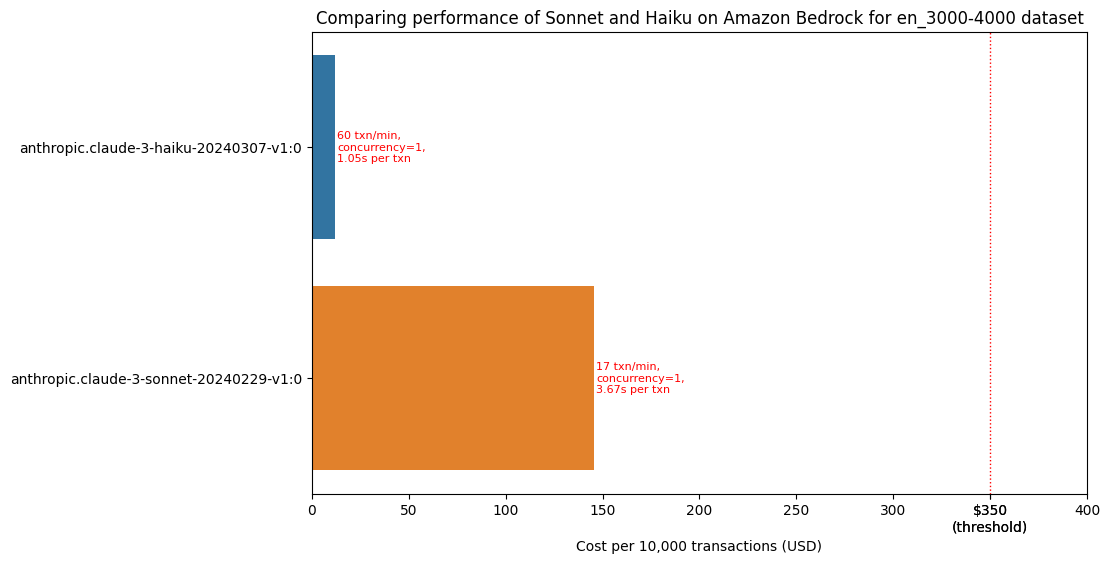

In [118]:
min_price_per_tx = df_summary_metrics_best_option_instance_type.price_per_txn.min()
txn_count_for_showing_cost: int = config["report"]["txn_count_for_showing_cost"]

price_tx_col_name = f"price_per_tx_{txn_count_for_showing_cost}_txn"
df_summary_metrics_best_option_instance_type[price_tx_col_name] = df_summary_metrics_best_option_instance_type.price_per_txn * txn_count_for_showing_cost
df_summary_metrics_best_option_instance_type[price_tx_col_name] = round(df_summary_metrics_best_option_instance_type[price_tx_col_name], 2)
df_summary_metrics_best_option_instance_type = df_summary_metrics_best_option_instance_type.sort_values(by=price_tx_col_name)
sns_plot = sns.barplot(df_summary_metrics_best_option_instance_type,
                       y="instance_type",
                       x=price_tx_col_name,
                       hue="instance_type",
                       orient='h')
sns_plot.axvline(x=config['report']['cost_per_10k_txn_budget'],
                 ls='dotted',
                 c='red',
                 linewidth=1) 
title: str = f"Comparing performance of {config['general']['model_name']} for {config['metrics']['dataset_of_interest']} dataset"
sns_plot.set(ylabel="", xlabel=f"Cost per {txn_count_for_showing_cost:,} transactions (USD)", title=title)

xticks = sns_plot.get_xticks()
xtick_labels = sns_plot.get_xticklabels()
#print(sns_plot.get_xticks(xticks))
sns_plot.set_xticks(np.append(xticks, config['report']['cost_per_10k_txn_budget']))
#print(sns_plot.get_xticks(xtick_labels))
sns_plot.set_xticklabels(np.append(xtick_labels,
                                   matplotlib.text.Text(config['report']['cost_per_10k_txn_budget'], 0, f"${config['report']['cost_per_10k_txn_budget']}\n(threshold)")))
print(sns_plot.get_xticklabels())
num_instance_types = len(df_summary_metrics_dataset.instance_type.unique())
for r in df_summary_metrics_best_option_instance_type.iterrows():
    y = r[1]['instance_type']
    if num_instance_types == 1:
        v_shift = config["report"]["v_shift_w_single_instance"]
    else:
        v_shift = config["report"]["v_shift_w_gt_one_instance"]

    print(f"v_shift={v_shift}")    
    x = r[1][price_tx_col_name] + v_shift + 1
    text = f"{r[1]['transactions_per_minute']} txn/min,\nconcurrency={r[1]['concurrency']},\n{r[1]['latency_p95']}s per txn"
    print(f"x={x}, y={y}, text={text}")
    sns_plot.text(x, y, text, 
       fontsize = 8,          # Size
       #fontstyle = "oblique",  # Style
       color = "red",          # Color
       ha = "left", # Horizontal alignment
       va = "center") # Vertical alignment 

business_summary_plot_fpath: str = os.path.join(METRICS_DIR, BUSINESS_SUMMARY_PLOT_FNAME2)
sns_plot.figure.savefig(buffer, format='png', bbox_inches='tight')
buffer.seek(0)

# Write the plot to S3
write_to_s3(buffer.getvalue(), BUCKET_NAME, "", "", business_summary_plot_fpath)
logger.info(f"Plot saved to s3://{BUCKET_NAME}/{business_summary_plot_fpath}")

# Display the plot 
sns_plot


In [119]:
df_summary_metrics_dataset['cost_per_10k_txn'] = df_summary_metrics_dataset.price_per_txn * 10000

In [120]:
CHARTS_PER_ROW: int = 2
fig = px.scatter(df_summary_metrics_dataset,
                 x="latency_p95",
                 y="cost_per_10k_txn",
                 size="transactions_per_minute",
                 color="instance_type", #",
                 facet_col="concurrency",
                 #symbol ="concurrency",
                 facet_col_wrap=CHARTS_PER_ROW,
                 #text="instance_type",
                 log_y=False,
                 #size_max=10,
                 category_orders={"concurrency": sorted(list(df_summary_metrics_dataset.concurrency))},
                 width=1000, height=600)

fig.for_each_yaxis(lambda y: y.update(title = ''))
fig.add_annotation(x=-0.05,y=0.5,
                   text="Cost per 10,000 requests (USD)", textangle=-90,
                   xref="paper", yref="paper")

fig.update_xaxes(title="")
fig.add_annotation(
    showarrow=False,
    xanchor='center',
    xref='paper', 
    x=0.5, 
    yref='paper',
    y=-0.1,
    text='p95 latency (seconds)'
)

fig.update_layout(legend={'title_text':''})

fig.add_vline(x=config['report']['latency_budget'], line_width=1, line_dash="dash", line_color="red")
fig.add_hline(y=config['report']['cost_per_10k_txn_budget'], line_width=1, line_dash="dash", line_color="red")

fig.add_shape(
        type="rect",
        x0=0,
        y0=0,
        x1=config['report']['latency_budget'],
        y1=config['report']['cost_per_10k_txn_budget'],
        fillcolor="pink",
        line_width=0,
        layer="below",
        row='all',
        col='all',
        exclude_empty_subplots=True
    )

title: str = f"{config['general']['model_name']} price|performance on the {config['metrics']['dataset_of_interest']} dataset"
#subtitle: str = "Hover over bubbles in the shaded quadrant to see best best price|performance options."
subtitle: str = "Bubbles in shaded quadrant represent experiments that satisfy price|performance costraints.<br>Larger the bubble the greater the transactions/minute."

fig.update_layout(title=dict(
                      text=f"{title}<br>{subtitle}",
                      x=0.5,
                      y=0.95,
                      xanchor='center',
                      yanchor='top'))

fig.update_layout(margin=dict(t=100))
fig.update_xaxes(rangemode="nonnegative")
# fig.update_layout(legend=dict(
#     yanchor="bottom",
#     y=-0.425,
#     xanchor="left",
#     x=0.01
# ))

# now is the tricky part to add annotation for the best price performance
# we have to identify the correct facet for the best entry and then correct
# row and col index for that facet
# we first identify the best entry as a json dictionary
# to find the index we sort all the concurrency levens in asc order
# then find the row col index by iterating but we are iterating from 1,1
# which is at the top left because that is how we sett it visually
# but the facets row col counter starts at bottom left so the col counter is
# correct but the row counter needs to be inverted
best_price_perf = df_summary_metrics_dataset_overall.to_dict(orient='records')[0]
best_price_perf_x = best_price_perf['instance_type']
best_price_perf_y = best_price_perf['price_per_txn']*10000
best_price_perf_avg_latency = best_price_perf['latency_p95']
best_price_perf_cost_per_10k = round(best_price_perf['price_per_txn']*10000, 2)
best_price_perf_instance_type = best_price_perf['instance_type']
best_price_perf_instance_count = best_price_perf['instance_count']
best_price_perf_tpm = best_price_perf['transactions_per_minute']
concurrencies = np.sort(df_summary_metrics_dataset.concurrency.unique())

concurrencies = list(df_summary_metrics_dataset.concurrency.unique())

c = 1
total_rows = math.ceil(len(concurrencies)/CHARTS_PER_ROW)
r = total_rows
for i, v in enumerate(np.sort(concurrencies)):
    logger.info(f"iter {i}, r={r}, c={c}, v={v}, "
                f"best_price_perf_concurrency={best_price_perf['concurrency']}")
    if v == best_price_perf['concurrency']: #best_price_perf['concurrency']:
        logger.info(f"iter={i}, match found, r={r}, c={c}")
        break
    if c == CHARTS_PER_ROW:
        r -= 1
        c = 1
        logger.info(f"iter {i}, reset r and c indexes, r={r}, c={c}")
    else:
        c += 1
        logger.info(f"iter {i}, incrementing c, c={c}")
    
best_facet_row = r
best_facet_col = c
logger.info(f"facet row col for best_price_perf, r={r}, total_rows={total_rows}, "
            f"best_facet_row={best_facet_row}, best_facet_col={best_facet_col}")

fig.add_annotation(
        x=best_price_perf_avg_latency,
        y=best_price_perf_cost_per_10k,
        text="best price|performance*",
        row=best_facet_row,
        col=best_facet_col,
        showarrow=True,
        arrowhead=1,
        exclude_empty_subplots=True)

instance_count_str = f"{best_price_perf_instance_count} instances of " if best_price_perf_instance_count > 1 else ""
fig.add_annotation(
    showarrow=False,
    xanchor='left',
    xref='paper', 
    x=0, 
    yref='paper',
    y=-0.15,
    text=f"*<b>best price|performance</b>: {instance_count_str}{best_price_perf_instance_type}, p95 latency {best_price_perf_avg_latency}s, 10k txn cost ${best_price_perf_cost_per_10k}, transactions/minute {best_price_perf_tpm}.",
)
fig.show()

[2024-08-12 23:42:17,463] p31041 {954209958.py:96} INFO - iter 0, r=1, c=1, v=1, best_price_perf_concurrency=1
[2024-08-12 23:42:17,464] p31041 {954209958.py:99} INFO - iter=0, match found, r=1, c=1
[2024-08-12 23:42:17,464] p31041 {954209958.py:111} INFO - facet row col for best_price_perf, r=1, total_rows=1, best_facet_row=1, best_facet_col=1


In [121]:
business_summary_plot_fpath: str = os.path.join(METRICS_DIR, BUSINESS_SUMMARY_PLOT_FNAME)

local_path: str = os.path.join(tempfile.tempdir, BUSINESS_SUMMARY_PLOT_FNAME)
pio.write_image(fig, local_path) 
upload_file_to_s3(BUCKET_NAME, local_path, business_summary_plot_fpath)
logger.info(f"writing business summary image from {local_path} to s3://{BUCKET_NAME}/{business_summary_plot_fpath}")

[2024-08-12 23:42:17,775] p31041 {245086894.py:6} INFO - writing business summary image from /tmp/business_summary.png to s3://sagemaker-fmbench-write-us-east-1-015469603702/fmbench-bedrock-anthropic-models-SageMaker-ExecutionRole-20240111T084686/data/metrics/yyyy=2024/mm=08/dd=12/hh=22/mm=16/business_summary.png


In [122]:
local_path: str = os.path.join(tempfile.tempdir, BUSINESS_SUMMARY_PLOT_FNAME.split('.')[0] + ".html")
fig.write_html(local_path)
business_summary_html_plot_fpath = business_summary_plot_fpath.split('.')[0] + ".html"
upload_file_to_s3(BUCKET_NAME, local_path, business_summary_html_plot_fpath)
logger.info(f"writing business summary image from {local_path} to s3://{BUCKET_NAME}/{business_summary_html_plot_fpath}")

[2024-08-12 23:42:18,039] p31041 {2012293385.py:5} INFO - writing business summary image from /tmp/business_summary.html to s3://sagemaker-fmbench-write-us-east-1-015469603702/fmbench-bedrock-anthropic-models-SageMaker-ExecutionRole-20240111T084686/data/metrics/yyyy=2024/mm=08/dd=12/hh=22/mm=16/business_summary.html


In [123]:
display(df_summary_metrics_best_option_instance_type)

,experiment_name,payload_file,instance_type,instance_count,concurrency,error_rate,prompt_token_count_mean,prompt_token_throughput,completion_token_count_mean,completion_token_throughput,...,score_dict,score,any_criterion_failed,error_rate_criterion_failed,latency_criterion_failed,cost_per_txn_criterion_failed,error_rate_text,latency_p95_text,price_per_10k_txn_text,price_per_tx_10000_txn
3,anthropic.claude-3-haiku-20240307-v1:0,payload_en_3000-4000.jsonl,anthropic.claude-3-haiku-20240307-v1:0,1.0,1,0.0,4515,4589,64,59,...,"{'score': 5.755464285714286, 'any_criterion_fa...",5.755464,False,False,False,False,<span style='color:green'>0.00</span>,<span style='color:green'>1.05</span>,<span style='color:green'>12.09</span>,12.09
8,anthropic.claude-3-sonnet-20240229-v1:0,payload_en_3000-4000.jsonl,anthropic.claude-3-sonnet-20240229-v1:0,1.0,1,0.0,4515,1360,69,19,...,"{'score': 4.849428571428572, 'any_criterion_fa...",4.849429,False,False,False,False,<span style='color:green'>0.00</span>,<span style='color:green'>3.67</span>,<span style='color:green'>145.80</span>,145.80


In [124]:
cost_csv_content_fpath = os.path.join(METRICS_DIR, SUMMARY_MODEL_ENDPOINT_COST_PER_INSTANCE)
logger.info(f"the cost information can be found in the csv file here -> {cost_csv_content_fpath}")

# Read the file from S3
try:
    cost_content = get_s3_object(BUCKET_NAME, cost_csv_content_fpath)

    # Use pandas to read the CSV content
    df_cost_metrics = pd.read_csv(io.StringIO(cost_content))
    logger.info(f"{cost_csv_content_fpath} read into dataframe of shape {df_cost_metrics.shape}")
    df_cost_metrics.head()
except Exception as e:
    logger.error(f"Error reading from S3: {e}")

# Replace NaN values with an empty string
# df_cost_metrics.fillna('', inplace=True)

df_cost_metrics.head()

# Convert df_cost_metrics to Markdown table
cost_mkdn_table = Tomark.table(df_cost_metrics.to_dict(orient='records'))

[2024-08-12 23:42:18,069] p31041 {3676473203.py:2} INFO - the cost information can be found in the csv file here -> fmbench-bedrock-anthropic-models-SageMaker-ExecutionRole-20240111T084686/data/metrics/yyyy=2024/mm=08/dd=12/hh=22/mm=16/endpoint_per_instance_per_run_costs.csv
[2024-08-12 23:42:18,222] p31041 {3676473203.py:10} INFO - fmbench-bedrock-anthropic-models-SageMaker-ExecutionRole-20240111T084686/data/metrics/yyyy=2024/mm=08/dd=12/hh=22/mm=16/endpoint_per_instance_per_run_costs.csv read into dataframe of shape (2, 5)


In [125]:
ep_metrics_summarized_fpath = os.path.join(METRICS_DIR, ENDPOINT_METRICS_SUMMARIZED_FNAME)
logger.info(f"the ep metrics summarized information can be found in the csv file here -> {ep_metrics_summarized_fpath}")

# Read the file from S3
try:
    cost_content = get_s3_object(BUCKET_NAME, ep_metrics_summarized_fpath)

    # Use pandas to read the CSV content
    df_ep_metrics_summarized = pd.read_csv(io.StringIO(cost_content))
    df_ep_metrics_summarized = df_ep_metrics_summarized.round(2)
    logger.info(f"{ep_metrics_summarized_fpath} read into dataframe of shape {df_ep_metrics_summarized.shape}")
    df_ep_metrics_summarized.head()
    # Convert df_cost_metrics to Markdown table
    endpoint_metrics_summarized_table = Tomark.table(df_ep_metrics_summarized.to_dict(orient='records'))
except Exception as e:
    logger.error(f"Error reading from S3: {e}")
    endpoint_metrics_summarized_table = "_No endpoint metrics data is available_."


[2024-08-12 23:42:18,237] p31041 {2713487255.py:2} INFO - the ep metrics summarized information can be found in the csv file here -> fmbench-bedrock-anthropic-models-SageMaker-ExecutionRole-20240111T084686/data/metrics/yyyy=2024/mm=08/dd=12/hh=22/mm=16/endpoint_metrics_summarized.csv
[2024-08-12 23:42:18,309] p31041 {2713487255.py:16} ERROR - Error reading from S3: An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist.


#### Get evaluation data and generate visualizations
---

In this portion of the metrics generation step, we use the data gathered from the evaluation step (if any) and use it to generate as follows:

1. Overall accuracy chart: This chart shows the overall accuracy as per majority voting on all candidate models evaluated by the panel of LLM evaluators. This gives users a high level business judgement as to the overall accuracy metrics for each model on the entire dataset.

1. Accuracy per candidate model per payload file: This chart shows a more granular view into the accuracy metrics per candidate model per payload file. Users can analyze this chart to view and spot trends within the accuracy trajectory as the prompt size increases or decreases.

In [126]:
# check if the merged long df exists that contains the variable and accuracy value
# per payload file per candidate model to generate the per payload accuracy chart
per_model_per_payload_accuracy_counts_fpath = os.path.join(METRICS_DIR,
                                                           PER_PAYLOAD_MODEL_ACCURACY_MAJORITY_VOTING)
try:
    per_payload_content = get_s3_object(BUCKET_NAME,
                            per_model_per_payload_accuracy_counts_fpath,
                            decode='True')
except Exception as e:
    logger.error(f"{per_model_per_payload_accuracy_counts_fpath} not found in {BUCKET_NAME}")
    per_payload_content = None

if per_payload_content is None:
    model_evaluation_text_per_payload_accuracy: str = "_Per payload per model accuracy data is not available_."
else:
    from io import StringIO
    df_per_payload_evals = pd.read_csv(StringIO(per_payload_content))
    merged_accuracy_df_long_df = df_per_payload_evals.melt(id_vars=["candidate_model", "payload_file"])
    merged_accuracy_df_long_df.head()

In [127]:
df_per_payload_evals

,candidate_model,payload_file,judge_anthropic.claude-3-sonnet-20240229-v1:0_accuracy,judge_cohere.command-r-plus-v1:0_accuracy,judge_meta.llama3-70b-instruct-v1:0_accuracy,majority_voting_accuracy
0,anthropic.claude-3-haiku-20240307-v1:0,payload_en_1-500.jsonl,100.00,100.00,100.00,100.00
1,anthropic.claude-3-sonnet-20240229-v1:0,payload_en_1-500.jsonl,100.00,100.00,100.00,100.00
2,anthropic.claude-3-sonnet-20240229-v1:0,payload_en_500-1000.jsonl,100.00,100.00,100.00,100.00
3,anthropic.claude-3-haiku-20240307-v1:0,payload_en_500-1000.jsonl,100.00,100.00,100.00,100.00
4,anthropic.claude-3-haiku-20240307-v1:0,payload_en_1000-2000.jsonl,87.10,93.55,77.42,86.67
5,anthropic.claude-3-sonnet-20240229-v1:0,payload_en_1000-2000.jsonl,83.87,96.77,81.25,86.67
6,anthropic.claude-3-sonnet-20240229-v1:0,payload_en_2000-3000.jsonl,77.61,80.30,74.63,77.61
7,anthropic.claude-3-haiku-20240307-v1:0,payload_en_2000-3000.jsonl,77.27,77.27,73.85,77.27
8,anthropic.claude-3-haiku-20240307-v1:0,payload_en_3000-4000.jsonl,79.81,79.81,70.19,75.96
9,anthropic.claude-3-sonnet-20240229-v1:0,payload_en_3000-4000.jsonl,73.08,78.85,67.31,74.04


In [143]:
df_per_payload_evals.groupby('candidate_model').mean(numeric_only=True).reset_index()

,candidate_model,judge_anthropic.claude-3-sonnet-20240229-v1:0_accuracy,judge_cohere.command-r-plus-v1:0_accuracy,judge_meta.llama3-70b-instruct-v1:0_accuracy,majority_voting_accuracy
0,anthropic.claude-3-haiku-20240307-v1:0,88.836,90.126,84.292,87.980
1,anthropic.claude-3-sonnet-20240229-v1:0,86.912,91.184,84.638,87.664


### Calculate the Accuracy Trajectory Across Payload Sizes
---

In this portion of the evaluation step, the accuracy measure for each candidate model across each judge is calculated across different variations of payload sizes. This gives users more insights into accuracy measure for their desired payload size for their specific use case.

In [129]:
# check if model evals were enabled or not, if not then we just provide a canned message
majority_vote_per_model_accuracy_metrics_fpath = os.path.join(METRICS_DIR,
                                                              PER_MODEL_ACCURACY_PER_EVAL_JUDGE)
try:
    content = get_s3_object(BUCKET_NAME,
                            majority_vote_per_model_accuracy_metrics_fpath,
                            decode='True')
except Exception as e:
    logger.error(f"{majority_vote_per_model_accuracy_metrics_fpath} not found in {BUCKET_NAME}")
    content = None

if content is None:
    model_evaluation_text: str = "_Model evaluation data is not available_."
else:
    from io import StringIO
    df_evals = pd.read_csv(StringIO(content))
    num_judges = len(df_evals.judge_model_id.unique())
    model_count = len(df_evals.candidate_model.unique())
    judge_name_list = ", ".join(list(df_evals.judge_model_id.unique()))

In [130]:
def get_mean(text):
    import re

    # Regular expression to extract the numbers
    pattern = r"(\d+)-(\d+)"

    # Use re.search to find the numbers
    match = re.search(pattern, text)

    # Extract and print the numbers if a match is found
    if match:
        n1 = int(match.group(1))
        n2 = int(match.group(2))
        return (n1+n2)/2
    else:
        return None

try:
    data = merged_accuracy_df_long_df[merged_accuracy_df_long_df.variable == "majority_voting_accuracy"]
    data.payload_file = data.payload_file.map(lambda x: x.replace("payload_", "").replace(".jsonl", ""))
    data['mean_payload_size'] = data.payload_file.map(get_mean)
    data = data.sort_values(by="mean_payload_size")

    # dataset name
    ds_name = "LongBench"

    # Create the line + point plot
    fig = px.line(data, 
                  x='payload_file', 
                  y='value', 
                  color='candidate_model',
                  line_dash_sequence=['dash'],   # Set line style to dashed
                  symbol='candidate_model',      # Set different symbols based on candidate_model
                  markers=True)                  # Show points on the line

    # Update the trace for all symbols to be 'x'
    fig.update_traces(marker=dict(symbol='x', size=10))  # Set the marker to 'X' and adjust size

    # Update layout for y-axis range
    fig.update_layout(
        title=f'Model accuracy for prompts of different sizes in the \"{ds_name}\" dataset determined by a {num_judges} LLM judge panel through majority vote',
        yaxis=dict(
            range=[0, 110],
            title='Accuracy',
            ticksuffix='%',
        ),
        xaxis_title='Prompt size range',
        legend_title=None,
        width=1500,   # Set the width of the plot
        height=500   # Set the height of the plot
    )
    # Show the plot
    fig.show()
except Exception as e:
    logger.info(f"Error occured while generating per model per payload accuracy measure chart: {e}")

/tmp/ipykernel_31041/1344847057.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_31041/1344847057.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [131]:
try:
    per_model_per_payload_accuracy_fpath: str = os.path.join(METRICS_DIR, PER_PAYLOAD_FILE_ACCURACY_TRAJECTORY)

    local_path: str = os.path.join(tempfile.tempdir, PER_PAYLOAD_FILE_ACCURACY_TRAJECTORY)
    pio.write_image(fig, local_path) 
    upload_file_to_s3(BUCKET_NAME, local_path, per_model_per_payload_accuracy_fpath)
    logger.info(f"writing accuracy trajectory per payload file from {local_path} to s3://{BUCKET_NAME}/{per_model_per_payload_accuracy_fpath}")
except Exception as e:
    logger.info(f"Error occured while generating per model per payload accuracy measure chart: {e}")

[2024-08-12 23:42:18,880] p31041 {1467922215.py:7} INFO - writing accuracy trajectory per payload file from /tmp/accuracy_trajectory_per_payload.png to s3://sagemaker-fmbench-write-us-east-1-015469603702/fmbench-bedrock-anthropic-models-SageMaker-ExecutionRole-20240111T084686/data/metrics/yyyy=2024/mm=08/dd=12/hh=22/mm=16/accuracy_trajectory_per_payload.png


In [132]:
if content is not None:
    local_path: str = os.path.join(tempfile.tempdir, PER_PAYLOAD_FILE_ACCURACY_TRAJECTORY.split('.')[0] + ".html")
    fig.write_html(local_path)
    per_model_per_payload_accuracy_html_fpath = per_model_per_payload_accuracy_fpath.split('.')[0] + ".html"
    upload_file_to_s3(BUCKET_NAME, local_path, per_model_per_payload_accuracy_html_fpath)
    logger.info(f"writing business summary image from {local_path} to s3://{BUCKET_NAME}/{per_model_per_payload_accuracy_html_fpath}")

[2024-08-12 23:42:19,129] p31041 {1469525319.py:6} INFO - writing business summary image from /tmp/accuracy_trajectory_per_payload.html to s3://sagemaker-fmbench-write-us-east-1-015469603702/fmbench-bedrock-anthropic-models-SageMaker-ExecutionRole-20240111T084686/data/metrics/yyyy=2024/mm=08/dd=12/hh=22/mm=16/accuracy_trajectory_per_payload.html


### Compute the overall majority voting accuracy per candidate model
---

In this portion of the evaluation step, the overall accuracy (based on all majority votes) are calculated for each of the candidate model and displayed on a bar chart. This helps gather insights into an overall business judgement as to which model satisfies the accuracy criteria (configurable within the config file).

In [133]:
try:
    merged_accuracy_df_long_df.groupby(['candidate_model', 'variable'])['value'].mean().reset_index()
    majority_vote_accuracy_df = merged_accuracy_df_long_df.groupby(['candidate_model', 'variable'])['value'].mean().reset_index()
    majority_vote_accuracy_df = majority_vote_accuracy_df.sort_values(by="value", ascending=False)
    data = majority_vote_accuracy_df[majority_vote_accuracy_df.variable == "majority_voting_accuracy"]
    data
except Exception as e:
    logger.info(f"Error occured while getting the majority voting dataframe: {e}")

In [134]:
def findnth(haystack, needle, n):
    parts= haystack.split(needle, n+1)
    if len(parts)<=n+1:
        return -1
    return len(haystack)-len(parts[-1])-len(needle)

try:
    # Sample data
    data = majority_vote_accuracy_df[majority_vote_accuracy_df.variable == "majority_voting_accuracy"]
    data.candidate_model = data.candidate_model.map(lambda x: x.split(".")[1])

    # Define the y-coordinate for the dashed line
    threshold = 80
    dashed_line_y = threshold

    # dataset name
    ds_name = "LongBench"

    # models that have accuracy gte than threshold
    selected_models = data[data.value >= threshold].candidate_model.unique()
    num_selected_models = len(selected_models)
    if num_selected_models > 0:
        # if there are more than 3 models then text would not fit in one line so add
        # a line break after the 3rd model    
        selected_models_str = ", ".join(selected_models) + f" had accuracy >= {threshold}% "
        if selected_models_str.count(",") > 3:
            i = findnth(selected_models_str, ",", 2)       
            selected_models_str = list(selected_models_str)
            selected_models_str[i] = ",<br>"
            selected_models_str = "".join(selected_models_str).replace("<br> ", "<br>")
        selected_models_str = f"{num_selected_models} models, namely: " + selected_models_str
    else:
        selected_models_str = f"No candidate model(s) had accuracy >= the accuracy threshold of {threshold}%"

    # Create the bar chart with Plotly Express
    fig = px.bar(data,
                 x='candidate_model',
                 y='value',
                 #color='candidate_model',
                 title=f'Model accuracy on \"{ds_name}\" dataset determined by a {num_judges} LLM judge panel through majority vote<br>{selected_models_str}',
                 color='value', 
                 color_continuous_scale='Blues')

    # Add a dashed horizontal line
    fig.add_shape(
        type="line",
        x0=-0.5,
        y0=dashed_line_y,
        x1=len(data['candidate_model']) - 0.5,
        y1=dashed_line_y,
        line=dict(
            color="red",
            width=2,
            dash="dash"
        ),
        xref='x',
        yref='y'
    )

    # Add an annotation to the horizontal line
    fig.add_annotation(
        x=len(data['candidate_model']) - 1,  # Position at the end of the line
        y=dashed_line_y,
        text=f"Accuracy threshold {threshold}%",  # The text to display
        showarrow=False,
        yshift=10,  # Slightly move the annotation above the line
        font=dict(color="red", size=12)  # Customize the text style
    )
    
    # Add annotations on top of each bar
    for i, row in data.iterrows():
        fig.add_annotation(
            x=row['candidate_model'],  # X position (category)
            y=row['value'],    # Y position (value)
            text=f"{round(row['value'], 2)}%",  # Annotation text
            showarrow=False,    # No arrow, just the text
            yshift=10           # Shift text upward so it's above the bar
        )
    # Update layout for better readability based on the number of candidate models in the evaluation process
    width = max(model_count * 500, 1500)
    
    # Update layout for y-axis range
    fig.update_layout(
        yaxis=dict(
            range=[0, 100],
            title='Accuracy',
            ticksuffix='%',
        ),    
        xaxis_title='',
        width=width,   # Set the width of the plot
        height=500   # Set the height of the plot
    )

    fig.update_layout(showlegend=False, coloraxis_showscale=False)

    # Show the plot
    fig.show()
except Exception as e:
    logger.info(f"Error occured while generating the overall accuracy chart: {e}")

/tmp/ipykernel_31041/3226860383.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [135]:
try:
    overall_model_majority_voting_accuracy_fpath: str = os.path.join(METRICS_DIR, OVERALL_CANDIDATE_MODEL_MAJORITY_VOTING_ACCURACY)

    local_path: str = os.path.join(tempfile.tempdir, OVERALL_CANDIDATE_MODEL_MAJORITY_VOTING_ACCURACY)
    pio.write_image(fig, local_path) 
    upload_file_to_s3(BUCKET_NAME, local_path, overall_model_majority_voting_accuracy_fpath)
    logger.info(f"writing the overall candidate model accuracy (with majority voting) from {local_path} to s3://{BUCKET_NAME}/{overall_model_majority_voting_accuracy_fpath}")
except Exception as e:
    logger.info(f"Error occured while writing the overall accuracy chart to s3://{BUCKET_NAME}/{overall_model_majority_voting_accuracy_fpath}")

[2024-08-12 23:42:19,477] p31041 {2098176000.py:7} INFO - writing the overall candidate model accuracy (with majority voting) from /tmp/overall_candidate_model_majority_voting_accuracy.png to s3://sagemaker-fmbench-write-us-east-1-015469603702/fmbench-bedrock-anthropic-models-SageMaker-ExecutionRole-20240111T084686/data/metrics/yyyy=2024/mm=08/dd=12/hh=22/mm=16/overall_candidate_model_majority_voting_accuracy.png


In [136]:
if content is not None:
    local_path: str = os.path.join(tempfile.tempdir, OVERALL_CANDIDATE_MODEL_MAJORITY_VOTING_ACCURACY.split('.')[0] + ".html")
    fig.write_html(local_path)
    overall_model_majority_voting_accuracy_html_fpath = overall_model_majority_voting_accuracy_fpath.split('.')[0] + ".html"
    upload_file_to_s3(BUCKET_NAME, local_path, overall_model_majority_voting_accuracy_html_fpath)
    logger.info(f"writing business summary image from {local_path} to s3://{BUCKET_NAME}/{overall_model_majority_voting_accuracy_html_fpath}")

[2024-08-12 23:42:19,692] p31041 {1302960767.py:6} INFO - writing business summary image from /tmp/overall_candidate_model_majority_voting_accuracy.html to s3://sagemaker-fmbench-write-us-east-1-015469603702/fmbench-bedrock-anthropic-models-SageMaker-ExecutionRole-20240111T084686/data/metrics/yyyy=2024/mm=08/dd=12/hh=22/mm=16/overall_candidate_model_majority_voting_accuracy.html


In [137]:

# Convert df_per_payload_evals to Markdown table
df_temp = df_per_payload_evals.groupby('candidate_model').mean(numeric_only=True).reset_index().round(2)
# the first column of this dataframe is the candidate model name and the rest all 
# are accuracy metrics columns so we want to append a % to all this columns
df_temp.iloc[:, 1:] = df_temp.iloc[:, 1:].astype(str) + '%'
model_eval_accuracy_mkdn_table = Tomark.table(df_temp.to_dict(orient='records'))

In [138]:
# model evaluation text
if content is not None:
    model_evaluation_text: str = f"""Model evaluations were performed by a panel of {num_judges} LLM judges: {judge_name_list}. Model outputs were compared with ground truth available in the dataset by the judge models. The following charts provide the results of model evaluations.

{model_eval_accuracy_mkdn_table}
    
![Overall model accuracy]({OVERALL_CANDIDATE_MODEL_MAJORITY_VOTING_ACCURACY})  
View an interactive version of the overall accuracy chart [here]({os.path.basename(overall_model_majority_voting_accuracy_html_fpath)})

![Model accuracy trend across prompt sizes]({PER_PAYLOAD_FILE_ACCURACY_TRAJECTORY})  
View an interactive version of the accuracy trajectory chart [here]({os.path.basename(per_model_per_payload_accuracy_html_fpath)})
"""

In [139]:
BUSINESS_SUMMARY: str = """We did performance benchmarking for `{model_name}` on "{instance_types}" on multiple datasets and based on the test results the best price performance for dataset `{ds}` is provided by the `{selected_instance_type}`.

{mkdn_table}

The price performance comparison for different instance types is presented below. An interactive version of this chart is available [here]({business_summary_plot_interactive_fpath}).

![Price performance comparison]({business_summary_plot_fpath})

### Latency Metrics Analysis

The following table provides token latency metrics including the overall latency, Time To First Token (TTFT), and Time Per Output Token (TPOT) for the `{ds}` dataset.

{latency_metrics_table}

### Failed experiments

{failed_experiment_text}

{failed_experiment_table}

### Model evaluations

{model_evaluation_text}

### Endpoint metrics

The following table provides endpoint utilization and invocation metrics.

{endpoint_metrics_summarized_table}

### Configuration

The configuration used for these tests is available in the [`config`](#configuration-file) file.

### Experiment cost

The cost to run each experiment is provided in the table below. The total cost for running all experiments is {total_cost_as_str}.



{cost_table}

"""
transposed_list = []
logger.info(f"df_summary_metrics_dataset_overall is: {df_summary_metrics_dataset_overall.columns}")
logger.info(f"df_summary_metrics_dataset instance types: {df_summary_metrics_dataset.instance_type}")
best_instance_type_info = df_summary_metrics_dataset_overall.to_dict(orient='records')[0]
cols_to_delete = ["score",
                  "score_dict",
                  "any_criterion_failed",
                  "latency_criterion_failed",
                  "cost_per_txn_criterion_failed",
                  "error_rate_criterion_failed",
                  "error_rate_text",
                  "latency_p95_text",
                  "price_per_10k_txn_text"]

for c in cols_to_delete:
    del best_instance_type_info[c]

# we want to convert all the latency/TTFT/TTLT/TPOT columns into one single column
# for e.g. latency mean|p50|p95|p99: 0.044 | 0.45 | 0.6 | 0.789
latency_prefixes = ['latency_', 'TTFT_', 'TPOT_']
latency_suffixes = ["p50", "p95", "p99"]
latency_cols = []
new_dict = {}
for c in latency_prefixes:
    # remove the underscore from the end
    new_col = c[:-1] + ' '
    new_val = ''
    for s in latency_suffixes:
        col_to_delete = c + s
        # check if this key exists, it may not exist for some metric
        # for example we dont keep p95 for TPOT only p50 and p99
        if best_instance_type_info.get(col_to_delete) is None:
            continue
        new_col += s + ", "
        val = best_instance_type_info[col_to_delete]
        # somewhere in the code mean has been rounded to 6
        # cant find where, round it to 4
        if s == "mean":
            val = round(val, 4)
        new_val += str(val) + ", "
        logger.info(f"c={c}, s={s}, col_to_delete={col_to_delete}, new_val={new_val}")
        latency_cols.append(col_to_delete)
    # remove the underscore from the end
    new_col = new_col[:-2]
    new_val = new_val[:-2]
    logger.info(f"new_col={new_col}, new_val={new_val}")
    new_dict[new_col] = new_val

# we dont want a colum each for each combination of latency metric and suffix
# we want all latency statistical summary metrics in a single row for ease of display
# so now that we have it that way in a new dict so first delete those columns from
# the old dictionary
for c in latency_cols:
    del best_instance_type_info[c]
# now merge the new dict with the old dict
best_instance_type_info = best_instance_type_info | new_dict
#logger.info(f"new_dict={new_dict}")
for k, v in best_instance_type_info.items():
    transposed_list.append({"Information": k, "Value": v})
mkdn_table = Tomark.table(transposed_list)


# Define the prefixes and columns for latency-related metrics
latency_index_cols = ['experiment_name', 'instance_type', 'concurrency']
df_summary_latency_metrics_dataset = df_summary_metrics_dataset[latency_index_cols + latency_cols]
latency_metrics_table = "_No token latency metrics data is available. To get token latency metrics enable streaming responses by setting `stream: True` in experiment configuration_."
if 'TTFT_p50' in df_summary_latency_metrics_dataset.columns:
    if all(df_summary_latency_metrics_dataset.TTFT_p50.isnull()):
        logger.info(f"all TTFT metrics are null, so no token latency metrics are available")        
    else:
        latency_metrics_table = Tomark.table(df_summary_latency_metrics_dataset.to_dict(orient='records'))
else:
    logger.info(f"TTFT metrics fields are not available, looks like no experiment had streaming enabled")        
    
    
experiments_w_some_criterion_failed = df_summary_metrics_dataset.any_criterion_failed.sum()
perf_criteria_text = f"""`Latency` < `{config['report']['latency_budget']}s`, `cost per 10k transactions`: `${config['report']['cost_per_10k_txn_budget']}`, `error rate`: `{config['report']['error_rate_budget']}`"""
if experiments_w_some_criterion_failed > 0:
    logger.info(f"a total of {experiments_w_some_criterion_failed} experiment run(s) failed at least one criterion")
    failed_experiment_text = f"""There were a total of {experiments_w_some_criterion_failed} experiment run(s) that failed at least one configured performance criteria: {perf_criteria_text}. See table below.    
    """
    failed_experiment_table = Tomark.table(df_summary_metrics_dataset[df_summary_metrics_dataset.any_criterion_failed == True][['experiment_name',
                                         'payload_file',
                                         'concurrency',
                                         'error_rate_text',
                                         'latency_p95_text',
                                         'price_per_10k_txn_text']].to_dict('records'))
else:
    failed_experiment_text = f"""All experiments satisfied the configured performance criteria: {perf_criteria_text}."""
    failed_experiment_table = ""




plural = "s" if len(df_summary_metrics.instance_type.unique()) > 1 else ""
instance_types_md = ", ".join([f"`{it}`" for it in df_summary_metrics.instance_type.unique()])
selected_instance_type: str = df_summary_metrics_dataset_overall.to_dict(orient='records')[0]['instance_type']
ds: str = config['metrics']['dataset_of_interest']

business_summary: str = BUSINESS_SUMMARY.format(model_name=config['general']['model_name'],
                                                instance_types=instance_types_md,
                                                plural=plural,
                                                ds=ds,
                                                selected_instance_type=selected_instance_type,
                                                mkdn_table="\n" + mkdn_table + "\n",
                                                failed_experiment_text="\n" + failed_experiment_text + "\n",
                                                failed_experiment_table="\n" + failed_experiment_table + "\n",
                                                endpoint_metrics_summarized_table=endpoint_metrics_summarized_table,
                                                latency_metrics_table="\n" + latency_metrics_table + "\n",
                                                cfg_file_path=os.path.basename(CONFIG_FILE),
                                                business_summary_plot_fpath=BUSINESS_SUMMARY_PLOT_FNAME,
                                                business_summary_plot_interactive_fpath=os.path.basename(business_summary_html_plot_fpath),
                                                cost_table=cost_mkdn_table,
                                                model_evaluation_text=model_evaluation_text,
                                                total_cost_as_str=f"${df_cost_metrics.cost.sum():.2f}")
business_summary

[2024-08-12 23:42:19,736] p31041 {4074166557.py:45} INFO - df_summary_metrics_dataset_overall is: Index(['experiment_name', 'payload_file', 'instance_type', 'instance_count',
       'concurrency', 'error_rate', 'prompt_token_count_mean',
       'prompt_token_throughput', 'completion_token_count_mean',
       'completion_token_throughput', 'latency_p50', 'latency_p95',
       'latency_p99', 'transactions_per_minute', 'price_per_txn',
       'price_per_token', 'score_dict', 'score', 'any_criterion_failed',
       'error_rate_criterion_failed', 'latency_criterion_failed',
       'cost_per_txn_criterion_failed', 'error_rate_text', 'latency_p95_text',
       'price_per_10k_txn_text'],
      dtype='object')
[2024-08-12 23:42:19,738] p31041 {4074166557.py:46} INFO - df_summary_metrics_dataset instance types: 3     anthropic.claude-3-haiku-20240307-v1:0
8    anthropic.claude-3-sonnet-20240229-v1:0
Name: instance_type, dtype: object
[2024-08-12 23:42:19,741] p31041 {4074166557.py:84} INFO - c=l

'We did performance benchmarking for `Sonnet and Haiku on Amazon Bedrock` on "`anthropic.claude-3-haiku-20240307-v1:0`, `anthropic.claude-3-sonnet-20240229-v1:0`" on multiple datasets and based on the test results the best price performance for dataset `en_3000-4000` is provided by the `anthropic.claude-3-haiku-20240307-v1:0`.\n\n\n| Information | Value |\n|-----|-----|\n| experiment_name | anthropic.claude-3-haiku-20240307-v1:0 |\n| payload_file | payload_en_3000-4000.jsonl |\n| instance_type | anthropic.claude-3-haiku-20240307-v1:0 |\n| instance_count | 1.0 |\n| concurrency | 1 |\n| error_rate | 0.0 |\n| prompt_token_count_mean | 4515 |\n| prompt_token_throughput | 4589 |\n| completion_token_count_mean | 64 |\n| completion_token_throughput | 59 |\n| transactions_per_minute | 60 |\n| price_per_txn | 0.001209 |\n| price_per_token | 0.00000026 |\n| latency p50, p95, p99 | 1.05, 1.05, 1.05 |\n| TTF |  |\n| TPO |  |\n\n\n\nThe price performance comparison for different instance types is p

In [140]:
from typing import Optional
dttm = str(datetime.utcnow())
datasets_used = ", ".join([f"`{d}`" for d in config['s3_read_data']['source_data_files']])
title = config['report'].get('title',
                             f"Results for performance benchmarking {config['general']['model_name']}")
overall_results_md = OVERALL_RESULTS_MD.format(title=title,
                                               dttm=dttm,
                                               fmbench_version=fmbench_version,
                                               business_summary=business_summary, 
                                               datasets=datasets_used)
results_group_cols: List[str] = ['instance_type', 'payload_file']
result_rows: List[str] = []
latency_budget: int = config['report'].get('latency_budget',
                                           LATENCY_BUDGET)

for row in df_summary_metrics[results_group_cols].drop_duplicates().iterrows():
    instance_type = row[1]['instance_type']
    dataset = row[1]['payload_file']
    df_summary_metrics_nz_subset = df_summary_metrics_nz[(df_summary_metrics_nz.instance_type == instance_type) &
                                                          (df_summary_metrics_nz.payload_file == dataset) &
                                                           (df_summary_metrics_nz.latency_p95 <= latency_budget)]
    num_results = df_summary_metrics_nz_subset.shape[0]
    result_row: Optional[str] = None
    if num_results > 0:
        logger.info(f"there are {num_results} options to choose the best option from for instance_type={instance_type}, dataset={dataset}")
        df_summary_metrics_nz_subset_selected = df_summary_metrics_nz_subset[df_summary_metrics_nz_subset.concurrency == df_summary_metrics_nz_subset.concurrency.max()]
        best = df_summary_metrics_nz_subset_selected.to_dict(orient='records')[0]
        best_instance_type= best['instance_type']
        # logger.info(best)
        result_desc = RESULT_DESC.format(latency_budget=latency_budget,
                           instance_type=best_instance_type,
                           dataset=dataset,
                           concurrency=best['concurrency'],
                           latency_median=best['latency_p50'],
                           prompt_size=int(best['prompt_token_count_mean']),
                           completion_size=int(best['completion_token_count_mean']),
                           tpm=int(best['transactions_per_minute']))     

    else:
        logger.info(f"there are NO options to choose from for instance_type={instance_type}, dataset={dataset}")
        best_instance_type= instance_type
        result_desc = RESULT_FAILURE_DESC.format(latency_budget=latency_budget,
                                                 instance_type=instance_type,
                                                 dataset=dataset)
    result_row: str = RESULT_ROW.format(instance_type=best_instance_type,
                                        dataset=dataset,
                                        desc=result_desc)
    result_rows.append(result_row)

overall_results_md += "\n".join(result_rows)

OVERALL_RESULTS_PLOTS_MD: str = """

## Plots

The following plots provide insights into the results from the different experiments run.

![{plot1_text}]({plot1_fname})

![{plot2_text}]({plot2_fname})

![{plot3_text}]({plot3_fname})
"""

overall_results_plots_md: str = OVERALL_RESULTS_PLOTS_MD.format(plot1_text=ERROR_RATES_PLOT_TEXT, 
                                                                plot1_fname=ERROR_RATES_PLOT_FNAME,
                                                                plot2_text=TOKENS_VS_LATENCY_PLOT_TEXT, 
                                                                plot2_fname=TOKENS_VS_LATENCY_PLOT_FNAME,
                                                                plot3_text=CONCURRENCY_VS_INFERENCE_LATENCY_PLOT_TEXT, 
                                                                plot3_fname=CONCURRENCY_VS_INFERENCE_LATENCY_PLOT_FNAME)

overall_results_md += overall_results_plots_md

# dump the config file at the end so that there is a record of what 
# we tested with
# write the config file in the results directory for record sake
import yaml
class VerboseSafeDumper(yaml.SafeDumper):
    def ignore_aliases(self, data):
        return True

config_yml = yaml.dump(config, Dumper=VerboseSafeDumper)
config_dump = f"""\n\n
## Configuration file
```.bash
{config_yml}
```
"""
overall_results_md += config_dump


fpath: str = os.path.join(METRICS_DIR, RESULTS_DESC_MD_FNAME)
logger.info(f"writing final markdown to {METRICS_DIR}")
Path(fpath).write_text(overall_results_md)
logger.info(overall_results_md)

# Write the CSV data to S3
write_to_s3(overall_results_md, BUCKET_NAME, "", METRICS_DIR, RESULTS_DESC_MD_FNAME)
logger.info(f"results.md file saved to to s3://{BUCKET_NAME}/{METRICS_DIR}/{RESULTS_DESC_MD_FNAME}")

[2024-08-12 23:42:19,777] p31041 {4071145682.py:25} INFO - there are 1 options to choose the best option from for instance_type=anthropic.claude-3-haiku-20240307-v1:0, dataset=payload_en_1-500.jsonl
[2024-08-12 23:42:19,781] p31041 {4071145682.py:25} INFO - there are 1 options to choose the best option from for instance_type=anthropic.claude-3-haiku-20240307-v1:0, dataset=payload_en_1000-2000.jsonl
[2024-08-12 23:42:19,786] p31041 {4071145682.py:25} INFO - there are 1 options to choose the best option from for instance_type=anthropic.claude-3-haiku-20240307-v1:0, dataset=payload_en_2000-3000.jsonl
[2024-08-12 23:42:19,790] p31041 {4071145682.py:25} INFO - there are 1 options to choose the best option from for instance_type=anthropic.claude-3-haiku-20240307-v1:0, dataset=payload_en_3000-4000.jsonl
[2024-08-12 23:42:19,796] p31041 {4071145682.py:25} INFO - there are 1 options to choose the best option from for instance_type=anthropic.claude-3-haiku-20240307-v1:0, dataset=payload_en_500-1

In [141]:
#save all the metrics and report files locally
import time
import shutil
shutil.rmtree(RESULTS_DIR, ignore_errors=True)
time.sleep(10)
os.makedirs(RESULTS_DIR, exist_ok=False)

# config_yml = yaml.dump(config, default_flow_style=False)
fpath: str = os.path.join(RESULTS_DIR, os.path.basename(CONFIG_FILE))
logger.info(f"saving config yaml in file {fpath}")
Path(fpath).write_text(config_yml)

logger.info(f"going to download all metrics and reports from s3 into {RESULTS_DIR} directory")
download_multiple_files_from_s3(BUCKET_NAME, METRICS_DIR, RESULTS_DIR)
import glob
result_files = glob.glob(os.path.join(RESULTS_DIR, "**"), recursive=True)
logger.info("\n".join([f for f in result_files]))

[2024-08-12 23:42:30,008] p31041 {3951884529.py:10} INFO - saving config yaml in file results-fmbench-bedrock-anthropic-models/config-bedrock-haiku-sonnet-majority-voting.yml
[2024-08-12 23:42:30,012] p31041 {3951884529.py:13} INFO - going to download all metrics and reports from s3 into results-fmbench-bedrock-anthropic-models directory
[2024-08-12 23:42:30,013] p31041 {utils.py:375} INFO - download_multiple_files_from_s3, bucket_name=sagemaker-fmbench-write-us-east-1-015469603702, prefix=fmbench-bedrock-anthropic-models-SageMaker-ExecutionRole-20240111T084686/data/metrics/yyyy=2024/mm=08/dd=12/hh=22/mm=16, local_dir=results-fmbench-bedrock-anthropic-models
[2024-08-12 23:42:30,554] p31041 {utils.py:319} INFO - found 1000 items in bucket=sagemaker-fmbench-write-us-east-1-015469603702, prefix=fmbench-bedrock-anthropic-models-SageMaker-ExecutionRole-20240111T084686/data/metrics/yyyy=2024/mm=08/dd=12/hh=22/mm=16, suffix=None
[2024-08-12 23:42:30,591] p31041 {utils.py:319} INFO - found 11

In [142]:
import docker
import subprocess
docker_running = False
generate_html_report = config['report'].get('generate_html_report', True)

if generate_html_report is True:
    try:
        docker_client = docker.DockerClient()
        docker_running = docker_client.ping()
    except Exception as e:
        print(f"seems like docker is not installed or not running, exception={e}")

    if docker_running is True:
        report_md_path = f"{os.getcwd()}/{RESULTS_DIR}"
        report_html_path = os.path.join(report_md_path, f"{config['general']['name']}.html")
        cmd = f"docker run --rm -v {report_md_path}:/public -w /public -u $(id -u):$(id -g) registry.gitlab.com/quarto-forge/docker/quarto quarto render report.md --to html --self-contained"
        logger.info(f"going to create self-conained html report with cmd=\"{cmd}\"")
        process = subprocess.Popen(cmd,
                                   stdout=subprocess.PIPE, 
                                   stderr=subprocess.PIPE,
                                   text=True,
                                   shell=True)
        std_out, std_err = process.communicate()
        logger.info(std_out.strip())
        logger.info(std_err)

    else:
        logger.error(f"docker is not available, not going to create self-conained html report")
else:
    logger.info(f"generate_html_report={generate_html_report}, skipping html report generation")

[2024-08-12 23:43:37,272] p31041 {1133856087.py:15} INFO - docker check, cmd=docker --version, std_out=Docker version 27.1.1, build 6312585
, std_err=
[2024-08-12 23:43:37,273] p31041 {1133856087.py:26} INFO - going to create self-conained html report with cmd="docker run --rm -v /home/sagemaker-user/repos/foundation-model-benchmarking-tool/src/fmbench/results-fmbench-bedrock-anthropic-models:/public -w /public -u $(id -u):$(id -g) registry.gitlab.com/quarto-forge/docker/quarto quarto render report.md --to html --self-contained"
[2024-08-12 23:43:37,291] p31041 {1133856087.py:33} INFO - 
[2024-08-12 23:43:37,292] p31041 {1133856087.py:34} INFO - docker: Cannot connect to the Docker daemon at unix:///var/run/docker.sock. Is the docker daemon running?.
See 'docker run --help'.

